# <center><span style='color:blue'>Projet 7 : Implémentez un modèle de scoring </span></center>

## <a id=''> Modélisations </a>

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
# !pip install jupyter_contrib_nbextensions && jupyter contrib nbextension install

Traceback (most recent call last):
  File "C:\Users\Aziz\anaconda3\envs\Projet6\Lib\site-packages\jupyter_contrib_core\notebook_compat\nbextensions.py", line 6, in <module>
    from notebook.extensions import BaseExtensionApp
ModuleNotFoundError: No module named 'notebook.extensions'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Aziz\anaconda3\envs\Projet6\Lib\site-packages\jupyter_contrib_core\notebook_compat\nbextensions.py", line 10, in <module>
    from notebook.nbextensions import BaseNBExtensionApp
ModuleNotFoundError: No module named 'notebook.nbextensions'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\Aziz\anaconda3\envs\Projet6\Scripts\jupyter-contrib.EXE\__main__.py", line 7, in <module>
  File "C:\Users\Aziz\anaconda3\envs


     ---------------------------------------- 0.0/23.5 MB ? eta -:--:--
     -- ------------------------------------- 1.6/23.5 MB 9.4 MB/s eta 0:00:03
     ----- ---------------------------------- 3.1/23.5 MB 8.4 MB/s eta 0:00:03
     -------- ------------------------------- 5.2/23.5 MB 8.9 MB/s eta 0:00:03
     ------------ --------------------------- 7.3/23.5 MB 8.7 MB/s eta 0:00:02
     ---------------- ----------------------- 9.4/23.5 MB 9.0 MB/s eta 0:00:02
     ------------------- -------------------- 11.5/23.5 MB 9.1 MB/s eta 0:00:02
     ----------------------- ---------------- 13.6/23.5 MB 9.3 MB/s eta 0:00:02
     -------------------------- ------------- 15.7/23.5 MB 9.4 MB/s eta 0:00:01
     ------------------------------- -------- 18.4/23.5 MB 9.6 MB/s eta 0:00:01
     ----------------------------------- --- 21.2/23.5 MB 10.0 MB/s eta 0:00:01
     --------------------------------------- 23.5/23.5 MB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing

## <a id='1'>1. Introduction</a>

----------------------------------------------------------------------------------------------------------------------------
Les données sont issues d'un concours organisé sur Kaggle par l'entreprise "**Home Credit**".

Home Credit est un service dédié à la fourniture de prêts à la population non bancarisée.
Prédire si un client remboursera ou non un prêt ou s'il aura des difficultés est un besoin commercial essentiel,
et Home Credit organise cette compétition sur Kaggle pour voir quel type de modèles la communauté
de l'apprentissage automatique peut développer pour l'aider dans cette tâche.

Il y a 7 sources de données différentes :

   *  **application_train/application_test** : les principales données de train et de test avec des informations sur chaque demande de prêt chez Home Credit. Chaque prêt a sa propre ligne et est identifié par la caractéristique SK_ID_CURR. Les données de train sont accompagnées de la caractéristique TARGET indiquant 0 : le prêt a été remboursé ou 1 : le prêt n'a pas été remboursé.
   
   
   *  **bureau** : données concernant les crédits antérieurs du client auprès d'autres institutions financières. Chaque crédit précédent a sa propre ligne dans bureau, mais un prêt existant dans application_(train|test) peut avoir plusieurs crédits précédents.
   
   
   *  **bureau_balance** : données mensuelles concernant les crédits précédents dans bureau. Chaque ligne correspond à un mois de crédit précédent, et un crédit précédent unique peut avoir plusieurs lignes, une pour chaque mois de la durée du crédit.
   
   
  * **previous_application** : demandes précédentes de prêts a Home Credit des clients qui ont des prêts dans les données de application_(train|test). Chaque prêt actuel dans les données de application_(train|test) peut avoir plusieurs prêts précédents. Chaque demande précédente a une ligne et est identifiée par la caractéristique SK_ID_PREV.
  
  
  * **POS_CASH_BALANCE** : données mensuelles sur les prêts au point de vente ou en espèces que les clients ont eu avec Home Credit. Chaque ligne correspond à un mois d'un prêt au point de vente ou d'un prêt en espèces précédent, et un seul prêt précédent peut avoir plusieurs lignes.
  
  
  * **credit_card_balance** : données mensuelles sur les cartes de crédit que les clients ont eu avec Home Credit. Chaque ligne correspond à un mois de solde de carte de crédit, et une seule carte de crédit peut avoir plusieurs lignes.
  
  
  *  **installments_payment** : historique des paiements pour les prêts précédents chez Home Credit. Il y a une ligne pour chaque paiement effectué et une ligne pour chaque paiement manqué.

_________________


## <a id='2'>2. Importation des librairies</a>

In [4]:
import numpy as np
import pandas as pd
import math
import time
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from contextlib import contextmanager
import importlib
import pickle
import mlflow
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, learning_curve
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
import re

from evidently.report import Report
from evidently.metrics import DataDriftTable, DatasetDriftMetric
pd.options.display.max_columns = 200
np.random.seed(0)

## <a id='3'>3. Connexion serveur MLflow en local </a>

-  MLflow permet de se connecter au serveur pour le suivi des expériences de machine learning.

- Serveur MLflow en local : Si vous utilisez le serveur MLflow en local, l'adresse est généralement http://127.0.0.1:5000/ par défaut. Cela signifie que le serveur MLflow est accessible sur votre ordinateur local (localhost) via le port 5000. Vous pouvez ouvrir votre navigateur et accéder à cette adresse pour voir l'interface utilisateur MLflow.

In [5]:
#Connexion en local
mlflow.set_tracking_uri('http://127.0.0.1:5000/')

## <a id="4">4. Importation des données </a>

In [6]:
train_df = pd.read_csv("train_df_cleaned.csv")

In [7]:
test_df= pd.read_csv("test_df_cleaned.csv")

In [8]:
train_df.sample(2)

SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
289122      434951       0            1             0                0   
188488      318534       0            1             0                0   

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
289122             0           76500.0     67500.0       5773.5   
188488             0          135000.0    225000.0      16434.0   

        AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
289122          67500.0                    0.024610   30.654795   
188488         225000.0                    0.018634   48.063014   

        DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  \
289122         3421.0             2429.0           3209.0           1   
188488        10572.0            10142.0           1069.0           1   

        FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
289122               1                1                 1           0   
188488               1                1                 1           1   

        FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
289122           0              2.0                     2   
188488           0              2.0                     2   

        REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
289122                            2                       14   
188488                            2                        9   

        REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
289122                           0                           0   
188488                           0                           0   

        LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
289122                            0                       0   
188488                            0                       0   

        REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_2  \
289122                       0                        0      0.781996   
188488                       0                        0      0.508120   

        EXT_SOURCE_3  YEARS_BEGINEXPLUATATION_AVG  FLOORSMAX_AVG  \
289122      0.583238                       0.9762         0.1667   
188488      0.572683                       0.9816         0.1667   

        YEARS_BEGINEXPLUATATION_MODE  FLOORSMAX_MODE  \
289122                        0.9762          0.1667   
188488                        0.9816          0.1667   

        YEARS_BEGINEXPLUATATION_MEDI  FLOORSMAX_MEDI  TOTALAREA_MODE  \
289122                        0.9762          0.1667          0.0311   
188488                        0.9816          0.1667          0.0688   

        OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  \
289122                       4.0                       1.0   
188488                       0.0                       0.0   

        OBS_60_CNT_SOCIAL_CIRCLE  DEF_60_CNT_SOCIAL_CIRCLE  \
289122                       4.0                       1.0   
188488                       0.0                       0.0   

        DAYS_LAST_PHONE_CHANGE  FLAG_DOCUMENT_2  FLAG_DOCUMENT_3  \
289122                  1421.0                0                1   
188488                  1636.0                0                0   

        FLAG_DOCUMENT_4  FLAG_DOCUMENT_5  FLAG_DOCUMENT_6  FLAG_DOCUMENT_7  \
289122                0                0                0                0   
188488                0                0                0                0   

        FLAG_DOCUMENT_8  FLAG_DOCUMENT_9  FLAG_DOCUMENT_10  FLAG_DOCUMENT_11  \
289122                0                0                 0                 0   
188488                1                0                 0                 0   

        FLAG_DOCUMENT_12  FLAG_DOCUMENT_13  FLAG_DOCUMENT_14  \
289122                 0                 0                 0   
188488                 0                 0                 0   

        FLAG_DOCUMENT_15  FLAG_DOCUMENT_16  FLAG_DOCUMENT_17  \
289122                 0                 0          

In [9]:
test_df.sample(2)

SK_ID_CURR  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
46222      437892            1             0                0             0   
16354      217905            1             0                0             0   

       AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
46222          180000.0    906700.5      29380.5         634500.0   
16354          103500.0     88285.5       4243.5          67045.5   

       REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
46222                    0.035792   61.213699         5745.0   
16354                    0.028663   66.780822         1648.0   

       DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  FLAG_EMP_PHONE  \
46222            12592.0           4136.0           1               1   
16354             3456.0           4763.0           1               0   

       FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
46222                0                 1           1           0   
16354                0                 1           1           0   

       CNT_FAM_MEMBERS  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
46222              2.0                     2                           -2   
16354              1.0                     2                           -2   

       HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
46222                       11                           0   
16354                        9                           0   

       REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
46222                           0                            0   
16354                           0                            0   

       REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  \
46222                       0                       0   
16354                       0                       0   

       LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_2  EXT_SOURCE_3  \
46222                        0      0.734167      0.746300   
16354                        0      0.564731      0.200926   

       YEARS_BEGINEXPLUATATION_AVG  FLOORSMAX_AVG  \
46222                       0.9776         0.3333   
16354                       0.9816         0.1667   

       YEARS_BEGINEXPLUATATION_MODE  FLOORSMAX_MODE  \
46222                        0.9777          0.3333   
16354                        0.9816          0.1667   

       YEARS_BEGINEXPLUATATION_MEDI  FLOORSMAX_MEDI  TOTALAREA_MODE  \
46222                        0.9776          0.3333          0.0386   
16354                        0.9816          0.1667          0.0928   

       OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  \
46222                       7.0                       0.0   
16354                       8.0                       2.0   

       OBS_60_CNT_SOCIAL_CIRCLE  DEF_60_CNT_SOCIAL_CIRCLE  \
46222                       7.0                       0.0   
16354                       8.0                       1.0   

       DAYS_LAST_PHONE_CHANGE  FLAG_DOCUMENT_2  FLAG_DOCUMENT_3  \
46222                   679.0                0                1   
16354                   920.0                0                1   

       FLAG_DOCUMENT_4  FLAG_DOCUMENT_5  FLAG_DOCUMENT_6  FLAG_DOCUMENT_7  \
46222                0                0                0                0   
16354                0                0                0                0   

       FLAG_DOCUMENT_8  FLAG_DOCUMENT_9  FLAG_DOCUMENT_10  FLAG_DOCUMENT_11  \
46222                0                0                 0                 0   
16354                0                0                 0                 0   

       FLAG_DOCUMENT_12  FLAG_DOCUMENT_13  FLAG_DOCUMENT_14  FLAG_DOCUMENT_15  \
46222                 0                 0                 0                 0   
16354                 0                 0                 0                 0   

       FLAG_DOCUMENT_16  FLAG_DOCUMENT_17  FLAG_DOCUMENT_18  FLAG_DOCUMENT_19  \
46222                 0                 0                 0  

In [10]:
# Affichez les colonnes ayant au moins un NaN
cols_with_nan = train_df.columns[train_df.isna().any()]
print("Colonnes avec des valeurs NaN :")
print(cols_with_nan)

Colonnes avec des valeurs NaN :
Index([], dtype='object')


In [11]:
import pandas as pd

# Supposons que train_df et test_df sont vos DataFrames respectifs

# Variables uniquement dans train_df mais pas dans test_df
variables_only_in_train = train_df.columns.difference(test_df.columns)

# Variables uniquement dans test_df mais pas dans train_df
variables_only_in_test = test_df.columns.difference(train_df.columns)

# Variables qui ne se trouvent pas dans les deux DataFrames
variables_only_in_both = variables_only_in_train.intersection(variables_only_in_test)

print("Variables uniquement dans les deux DataFrames :", variables_only_in_both)



Variables uniquement dans les deux DataFrames : Index([], dtype='object')


## <a id="5">5. Modélisation</a>


## <a id="5.1">5.1 séparation des données en train et test. </a>

In [12]:
X = train_df.drop(['SK_ID_CURR', 'TARGET',], axis=1)
y = train_df['TARGET']

In [13]:
X.sample(2)

CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
25859             0             1                1             2   
203692            0             1                1             0   

        AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
25859           337500.0   1288350.0      37800.0        1125000.0   
203692          270000.0    728460.0      38578.5         675000.0   

        REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
25859                     0.072508   44.301370          739.0   
203692                    0.011703   50.956164         1850.0   

        DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  FLAG_EMP_PHONE  \
25859              5141.0           1259.0           1               1   
203692             3236.0           1302.0           1               1   

        FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
25859                 0                 1           1           0   
203692                0                 1           0           1   

        CNT_FAM_MEMBERS  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
25859               4.0                     1                            1   
203692              2.0                     2                            2   

        HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
25859                         9                           0   
203692                       13                           0   

        REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
25859                            0                            0   
203692                           0                            0   

        REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  \
25859                        0                       0   
203692                       1                       1   

        LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_2  EXT_SOURCE_3  \
25859                         0      0.671426      0.607557   
203692                        1      0.681566      0.576209   

        YEARS_BEGINEXPLUATATION_AVG  FLOORSMAX_AVG  \
25859                        0.9717         0.1250   
203692                       0.9816         0.1667   

        YEARS_BEGINEXPLUATATION_MODE  FLOORSMAX_MODE  \
25859                         0.9717          0.1250   
203692                        0.9816          0.1667   

        YEARS_BEGINEXPLUATATION_MEDI  FLOORSMAX_MEDI  TOTALAREA_MODE  \
25859                         0.9717          0.1250          0.0362   
203692                        0.9816          0.1667          0.0688   

        OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  \
25859                        0.0                       0.0   
203692                       0.0                       0.0   

        OBS_60_CNT_SOCIAL_CIRCLE  DEF_60_CNT_SOCIAL_CIRCLE  \
25859                        0.0                       0.0   
203692                       0.0                       0.0   

        DAYS_LAST_PHONE_CHANGE  FLAG_DOCUMENT_2  FLAG_DOCUMENT_3  \
25859                     -0.0                0                1   
203692                   516.0                0                1   

        FLAG_DOCUMENT_4  FLAG_DOCUMENT_5  FLAG_DOCUMENT_6  FLAG_DOCUMENT_7  \
25859                 0                0                0                0   
203692                0                0                0                0   

        FLAG_DOCUMENT_8  FLAG_DOCUMENT_9  FLAG_DOCUMENT_10  FLAG_DOCUMENT_11  \
25859                 0                0                 0                 0   
203692                0                0                 0                 0   

        FLAG_DOCUMENT_12  FLAG_DOCUMENT_13  FLAG_DOCUMENT_14  \
25859                  0                 0                 0   
203692                 0                 0                 0   

        FLAG_DOCUMENT_15  FLAG_DOCUMENT_16  FLAG_DOCUMENT_17  \
25859                  0                 0                 0   
203692                 0                 1      

In [14]:
y.sample(2)

108536    0
189847    0
Name: TARGET, dtype: int64

In [15]:
# Nous devons retirer les caractères spéciaux des noms des features pour l'utilisation de certains modèles (LightGBM)
# X=train_df.copy()
# y=target
X = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
test_df = test_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

Ce code ci-dessous divise les données (X et y) en ensembles d'entraînement (X_train, y_train) et de validation (X_val, y_val) en utilisant la fonction train_test_split() avec un test_size de 20%, une stratification basée sur y et une seed random_state fixée à 0 pour la reproductibilité.

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, stratify=y, random_state=0)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(246005, 559) (246005,)
(61502, 559) (61502,)


Nous enregistrons les DataFrame X_train, X_val, y_train et y_val  dans les fichiers binaires "X_train.pkl" , "X_val.pkl", "y_train.pkl" et "y_val.pkl"  dans le répertoire "models". Nous allons réutiliser ces données ultérieurement en utilisant pickle.load() pour les charger à partir des fichiers binaires.

La sérialisation avec pickle est utile pour sauvegarder des objets Python complexes tels que des DataFrames, des modèles de machine learning, ou des résultats d'entraînement pour les réutiliser sans avoir à recréer les objets à chaque fois.

In [14]:
pickle.dump(X_train, open('models/X_train.pkl', 'wb'))
pickle.dump(y_train, open('models/y_train.pkl', 'wb'))
pickle.dump(X_val, open('models/X_val.pkl', 'wb'))
pickle.dump(y_val, open('models/y_val.pkl', 'wb'))

NameError: name 'X_train' is not defined

In [18]:
X_val, X_val_test, y_val, y_val_test = train_test_split(X_val, y_val, test_size=0.20, stratify=y_val, random_state=0)

print(X_val_test.shape, y_val_test.shape)
print(X_val.shape, y_val.shape)

(12301, 559) (12301,)
(49201, 559) (49201,)


In [19]:
pickle.dump(X_val, open('models/X_val.pkl', 'wb'))
pickle.dump(X_val_test, open('models/X_val_test.pkl', 'wb'))
pickle.dump(y_val, open('models/y_val.pkl', 'wb'))
pickle.dump(y_val_test, open('models/y_val_test.pkl', 'wb'))

In [20]:
colsd = X_train.select_dtypes(['float64' ]).columns

In [21]:
len(colsd)

387

In [22]:
 X_train.dtypes

CODE_GENDER                         int64
FLAG_OWN_CAR                        int64
FLAG_OWN_REALTY                     int64
CNT_CHILDREN                        int64
AMT_INCOME_TOTAL                  float64
                                   ...   
INSTAL_AMT_PAYMENT_SUM            float64
INSTAL_DAYS_ENTRY_PAYMENT_MAX     float64
INSTAL_DAYS_ENTRY_PAYMENT_MEAN    float64
INSTAL_DAYS_ENTRY_PAYMENT_SUM     float64
INSTAL_COUNT                      float64
Length: 559, dtype: object

## <a id="5.2">5.2 Standardisation des données</a>

In [23]:
cols = X_train.select_dtypes(['float64']).columns

X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_val_test_scaled = X_val_test.copy()
X_test_scaled = test_df.copy()

std_scale = StandardScaler()
std_scale.fit(X_train[cols])

X_train_scaled[cols] = std_scale.transform(X_train[cols])
X_val_scaled[cols] = std_scale.transform(X_val[cols])
X_val_test_scaled[cols] = std_scale.transform(X_val_test[cols])
X_test_scaled[cols] = std_scale.transform(test_df[cols])

In [24]:
pickle.dump(X_train_scaled, open('models/X_train_scaled.pkl', 'wb'))
pickle.dump(X_val_scaled, open('models/X_val_scaled.pkl', 'wb'))
pickle.dump(X_val_test_scaled, open('models/X_val_test_scaled.pkl', 'wb'))
pickle.dump(X_test_scaled, open('models/X_test_scaled.pkl', 'wb'))

In [25]:
X_train_scaled = pickle.load(open('models/X_train_scaled.pkl', 'rb'))
y_train = pickle.load(open('models/y_train.pkl', 'rb'))
X_val = pickle.load(open('models/X_val.pkl', 'rb'))
X_val_scaled = pickle.load(open('models/X_val_scaled.pkl', 'rb'))
y_val = pickle.load(open('models/y_val.pkl', 'rb'))
X_val_test = pickle.load(open('models/X_val_test.pkl', 'rb'))
X_val_test_scaled = pickle.load(open('models/X_val_test_scaled.pkl', 'rb'))
y_val_test = pickle.load(open('models/y_val_test.pkl', 'rb'))

Nous créons les fonctions que nous utiliserons dans la suite de la modélisation. Ces fonctions permettent notamment de calculer certaines métriques et graphes à des fins de comparaison des performances de nos modèles.

Nous crééons une métrique personnalisée ayant une approche métier. Le but ici est de pénaliser plus fortement les faux négatifs (mauvais client prédit bon client) qui engendrent une grande perte de capital. On suppose ici que le coût d’un FN (Faux Négatif) est dix fois supérieur au coût d’un FP (Faux Positif).

Nous calculerons également d'autres métriques telles que :
- **Accuracy** : somme de tous les vrais positifs et vrais négatifs qu'il divise par le nombre total d'instances. Il permet d'apporter une réponse à la question suivante : de toutes les classes positives et négatives, combien parmi elles ont été prédites correctement ? Des valeurs élevées de ce paramètre sont souvent souhaitables.
- **Precision** :  indique le rapport entre les prévisions positives correctes et le nombre total de prévisions positives. Ce paramètre répond donc à la question suivante : sur tous les enregistrements positifs prédits, combien sont réellement positifs ? 
- **Recall/Rappel** : paramètre qui permet de mesurer le nombre de prévisions positives correctes sur le nombre total de données positives. Il permet de répondre à la question suivante : sur tous les enregistrements positifs, combien ont été correctement prédits ? La mesure vise à minimiser les faux négatifs.
- **F1 score** : moyenne harmonique de la précision et du rappel. Il équivaut au double du produit de ces deux paramètres sur leur somme. Sa valeur est maximale lorsque le rappel et la précision sont équivalents. Il est particulièrement difficile de comparer deux modèles avec une faible précision et un rappel élevé. Le contraire est également vérifié. Dans ces conditions, le score F1 permet de mesurer ces deux paramètres simultanément.
- **Fbeta score** : généralisation de la F-measure qui ajoute un paramètre de configuration appelé beta. Une valeur bêta par défaut est 1.0, ce qui est identique à la mesure F. Une valeur bêta plus petite, telle que 0.5, donne plus de poids à la précision et moins au rappel, tandis qu'une valeur bêta plus grande, telle que 2.0, donne moins de poids à la précision et plus de poids au rappel dans le calcul du score. Ici nous donnons plus de poids au rappel qui minimise les faux négatifs.
- **ROC AUC score** : mesure de façon globale la performance d’un modèle de classification. Il indique à quel point le modèle est capable de faire la distinction entre les classes. Il est égal à 1 pour un modèle parfait et à 0.5 pour un modèle non-informatif. 

## <a id="5.3">5.3 Définition des fonctions pour l'evaluation des modèles</a>

In [26]:
def fonction_metier(y_true, y_pred):
    '''Créer un score métier à partir de la matrice de confusion.
    :param: y_true (vraies valeurs), y_pred (valeurs prédites par le modèle)
    :return: gain (score métier)
    '''
    TP_coeff = 0       # Vrais positifs
    FP_coeff = 0       # Faux positifs (prédit comme faisant défaut (1) mais ne fait pas défaut (0))
    FN_coeff = -10     # Faux négatifs (prédit comme ne faisant pas défaut (0) mais font défaut (1))
    TN_coeff = 1       # Vrais négatifs
    
    (TN, FP, FN, TP) = metrics.confusion_matrix(y_true, y_pred).ravel()
    
    gain = (TP*TP_coeff + TN*TN_coeff + FP*FP_coeff + FN*FN_coeff)/(TN+FP+FN+TP)
    
    return gain

def score_metier_max(y_pred_proba, y_true, verbose=True):
    '''Créer un graphique permettant de déterminer quel peut être le score max en fonction du threshold.
    :param: y_pred_proba (probabilités prédites par le modèle), y_true (vraies valeurs),
    verbose (affiche le graphe ou juste le score maximal)
    :return: graphique, 
    '''
    scores = []
    for threshold in np.linspace(0, 1, num=101):
        y_pred = np.where(y_pred_proba > threshold, 1, 0)
        score = fonction_metier(y_true, y_pred)
        scores.append(score)

    if verbose == True:
        score_max = max(scores)
        opti_threshold = np.linspace(0, 1, num=101)[scores.index(score_max)]
        y_pred = np.where(y_pred_proba > opti_threshold, 1, 0)
        
        print("Score métier maximum : {:.2f}".format(score_max))
        print("Threshold optimal : {}".format(opti_threshold))
        
        fig, ax = plt.subplots(figsize=(6, 5))
        plt.plot(np.linspace(0, 1, num=101), scores, label="model score")
        plt.axvline(x=opti_threshold, color='k', dashes=(0.5, 1), 
                    label="optimal threshold: {}".format(opti_threshold))
        
        plt.title("Score métier en fonction du threshold", fontsize=10)
        plt.xlabel("Thresholds", fontsize=10)
        plt.ylabel("Score métier", fontsize=10)
        plt.legend()
        plt.show()
     
    else:
        return max(scores)

    
def conf_mat_transform(y_true, y_pred):
    '''Créer et affiche la matrice de confusion.
    :param: y_true (vraies valeurs), y_pred (valeurs prédites par le modèle)
    :return: affiche la matrice de confusion
    '''
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    plt.figure(figsize = (6,4))
    sns.heatmap(conf_mat, annot=True, cmap="Blues")
    
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Matrice de confusion')


def eval_score(model, X_val, y_true, seuil=0.5):
    '''Calcule, affiche et enregistre les différentes métriques.
    :param: model, X_val (dataframe de validation), y_true (vraies valeurs),
    seuil (seuil de détermination des prédictions)
    :return: affiche (et return) les métriques, la matrice de confusion et la courbe ROC.
    '''    
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    y_pred = np.where(y_pred_proba > seuil, 1, 0)
    
    metier = fonction_metier(y_true, y_pred)
    accuracy = metrics.accuracy_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    f1_score = metrics.f1_score(y_true, y_pred)
    fbeta_score = metrics.fbeta_score(y_true, y_pred, beta=2)
    rocauc = metrics.roc_auc_score(y_true, y_pred)
    
    print('Score métier :{:.2f}'.format(metier))
    print('Accuracy score : {:.2f}'.format(accuracy))
    print('Precision score : {:.2f}'.format(precision))
    print('Recall score : {:.2f}'.format(recall))
    print('F1 score : {:.2f}'.format(f1_score))
    print('Fbeta score : {:.2f}'.format(fbeta_score))
    print('ROC AUC score : {:.2f}'.format(rocauc))
    
    
    conf_mat_transform(y_true, y_pred)
    
    fig, ax = plt.subplots(figsize=(6, 5))
    
    fpr, tpr, threshold = metrics.roc_curve(y_true, y_pred_proba)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Courbe ROC')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    return metier, accuracy, precision, recall, f1_score, fbeta_score, rocauc, y_pred_proba

## <a id="5.4"> 5.4 Equilibrage des données</a>

Il existe plusieurs méthodes pour équilibrer des données déséquilibrées dans le contexte de l'apprentissage automatique, en particulier en classification. Voici une liste des principales méthodes d'équilibrage des données :

1. **Sous-échantillonnage (undersampling) de la classe majoritaire :**
   - RandomUnderSampler **(à appliquer)**
   - TomekLinks **(à appliquer)**
   - EditedNearestNeighbours
   - AllKNN

2. **Sur-échantillonnage (oversampling) de la classe minoritaire :**
   - RandomOverSampler
   - SMOTE (Synthetic Minority Over-sampling Technique) **(à appliquer)**
   - ADASYN (Adaptive Synthetic Sampling)
   - Borderline-SMOTE
   - SVMSMOTE

3. **Combinaison de sous-échantillonnage et sur-échantillonnage (problème de memoire pour tester) :**
   - SMOTEENN (SMOTE + ENN)
   - SMOTETomek (SMOTE + TomekLinks)

4. **Utilisation de poids dans l'algorithme d'apprentissage :**
   - Assigner des poids différents aux classes dans les algorithmes d'apprentissage (par exemple, paramètre `class_weight` dans scikit-learn). **(à appliquer)**

5. **Génération de données synthétiques :**
   - GANs (Generative Adversarial Networks) pour générer de nouvelles données de la classe minoritaire.

6. **Ensemble methods:**
   - EasyEnsemble
   - BalanceCascade
   - RUSBoost
   - SMOTEBoost

7. **Utilisation de modèles de prétraitement spécifiques :**
   - NearMiss
   - Condensed Nearest Neighbors

Il peut être nécessaire de tester plusieurs méthodes et de les évaluer en fonction des métriques de performance appropriées pour notre tâche de classification.

Nous allons tester différentes méthodes afin de rééquilibrer nos classes qui sont composées à 91.93% de la target 0 contre 8.07% pour la target 1.

Nous testerons ces différentes méthodes avec l'algorithme *LogisticRegression*. 

verifier si mlflow a demarré : 

on tape ceci dans anacondaprompt **mlflow server --host 127.0.0.1 --port 5000**

et on comme resultat: **INFO:waitress:Serving on http://127.0.0.1:5000**

In [27]:
mlflow.autolog(log_input_examples=True, silent=True)

## <a id="5.4.1">5.4.1 Aucun rééquilibrage </a>

2023/08/10 17:54:56 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/

Score métier :0.13
Accuracy score : 0.92
Precision score : 0.51
Recall score : 0.02
F1 score : 0.05
Fbeta score : 0.03
ROC AUC score : 0.51


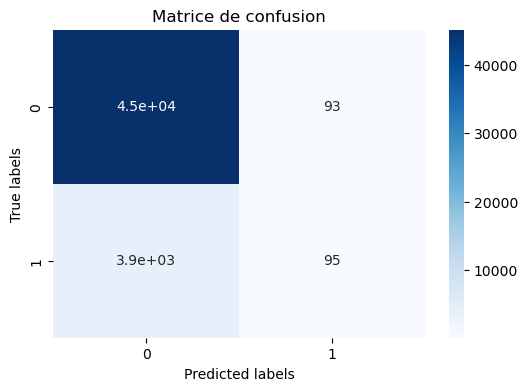

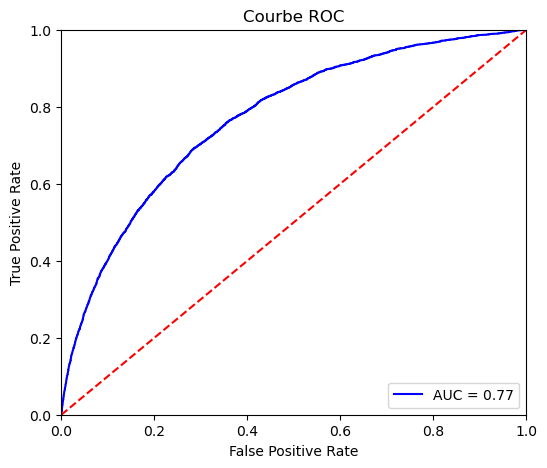

In [28]:
# Aucun rééquilibrage 

with mlflow.start_run(run_name='LogisticRegression sans équilibrage'):
    reg_log_inequal = LogisticRegression(max_iter=1000,random_state=0)
    reg_log_inequal.fit(X_train_scaled, y_train)

    # Calcul et enregistrement des metriques sur les données de validation
    score_metier, accuracy, precision, recall, f1_score, fbeta_score, rocauc, y_pred_proba =\
    eval_score(reg_log_inequal, X_val_scaled, y_val)
   
    mlflow.log_metric("val_score_métier", score_metier)
    mlflow.log_metric("val_accuracy", accuracy)
    mlflow.log_metric("val_precision", precision)
    mlflow.log_metric("val_recall", recall)
    mlflow.log_metric("val_f1_score", f1_score)
    mlflow.log_metric("val_fbeta_score", fbeta_score)
    mlflow.log_metric("val_rocauc", rocauc)

## <a id="5.4.2">5.4.2 Rééquilibrage avec class_weight</a>


La méthode des *class weight* permet de prendre en compte le caractère biaisé de la distribution du dataset et de créer un modèle pénalisé. Il s’agit ici de simplement attribuer des poids différents aux différentes classes de notre dataset, en donnant un poids plus important aux classes minoritaires, afin d’influencer le modèle lors de son entraînement. Nous pénalisons ainsi plus fortement une erreur de classification d’une classe minoritaire par rapport à une erreur de classification d’une classe majoritaire.

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Score métier :0.41
Accuracy score : 0.71
Precision score : 0.17
Recall score : 0.70
F1 score : 0.28
Fbeta score : 0.43
ROC AUC score : 0.70


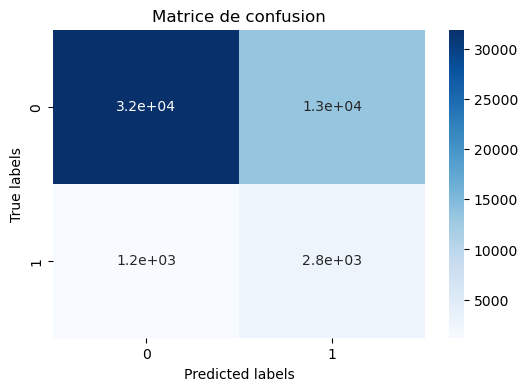

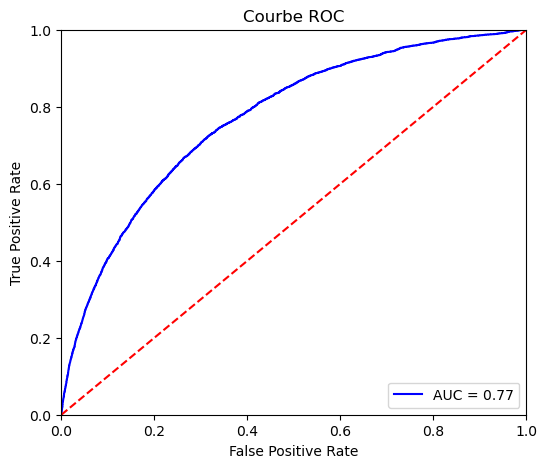

In [29]:
# Rééquilibrage avec class_weight

with mlflow.start_run(run_name='LogisticRegression class_weight'):
    reg_log_balanced = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=0)
    reg_log_balanced.fit(X_train_scaled, y_train)
    
    # Calcul et enregistrement des metriques sur les données de validation
    score_metier, accuracy, precision, recall, f1_score, fbeta_score, rocauc, y_pred_proba =\
    eval_score(reg_log_balanced, X_val_scaled, y_val)
   
    mlflow.log_metric("val_score_métier", score_metier)
    mlflow.log_metric("val_accuracy", accuracy)
    mlflow.log_metric("val_precision", precision)
    mlflow.log_metric("val_recall", recall)
    mlflow.log_metric("val_f1_score", f1_score)
    mlflow.log_metric("val_fbeta_score", fbeta_score)
    mlflow.log_metric("val_rocauc", rocauc)

## <a id="5.4.3">5.4.3 Rééquilibrage avec Sur-échantillonnage : SMOTE </a>



L'oversampling (sur-échantillonnage) est une technique utilisée pour remédier au déséquilibre de classes dans un jeu de données, où une classe est sous-représentée par rapport à une autre classe. L'objectif de l'oversampling est de générer des échantillons synthétiques de la classe minoritaire afin d'équilibrer les classes et d'améliorer les performances du modèle.

Le SMOTE, acronyme pour Synthetic Minority Oversampling TEchnique, est une méthode de suréchantillonnage des observations minoritaires. Pour éviter de réaliser un simple clonage des individus minoritaires, le SMOTE se base sur un principe simple : générer de nouveaux individus minoritaires qui ressemblent aux autres, sans être strictement identiques. Cela permet de densifier de façon plus homogène la population d’individus minoritaires.

Equilibre des classes : Counter({0: 226145, 1: 19860})
Equilibre des classes : Counter({0: 226145, 1: 226145})


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Score métier :0.13
Accuracy score : 0.92
Precision score : 0.50
Recall score : 0.03
F1 score : 0.05
Fbeta score : 0.03
ROC AUC score : 0.51


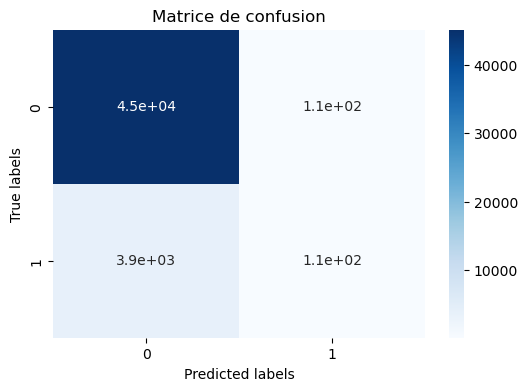

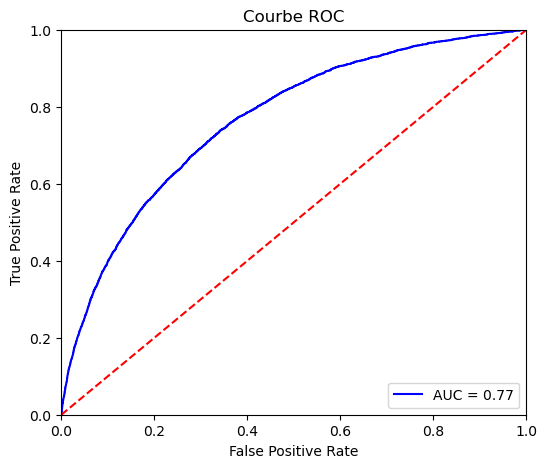

In [30]:
# Rééquilibrage avec Sur-échantillonnage (upsampling) de la classe minoritaire : SMOTE 

print('Equilibre des classes : {}'.format(Counter(y_train)))

# Définition de l'instance SMOTE
sm = SMOTE(random_state=0)

# Application du SMOTE aux données
X_train_sm, y_train_sm = sm.fit_resample(X_train_scaled, y_train)

print('Equilibre des classes : {}'.format(Counter(y_train_sm)))

with mlflow.start_run(run_name='LogisticRegression upsampling'):
    reg_log_up = LogisticRegression(max_iter=1000, random_state=0)
    reg_log_up.fit(X_train_sm, y_train_sm)
    
    # Calcul et enregistrement des metriques sur les données de validation
    score_metier, accuracy, precision, recall, f1_score, fbeta_score, rocauc, y_pred_proba =\
    eval_score(reg_log_up, X_val_scaled, y_val)
   
    mlflow.log_metric("val_score_métier", score_metier)
    mlflow.log_metric("val_accuracy", accuracy)
    mlflow.log_metric("val_precision", precision)
    mlflow.log_metric("val_recall", recall)
    mlflow.log_metric("val_f1_score", f1_score)
    mlflow.log_metric("val_fbeta_score", fbeta_score)
    mlflow.log_metric("val_rocauc", rocauc)

## <a id="5.4.4">5.4.4 Rééquilibrage avec Sous-échantillonnage : Tomek Links </a>

L'undersampling (sous-échantillonnage) est une technique utilisée pour remédier au déséquilibre de classes dans un jeu de données, où une classe est sur-représentée par rapport à une autre classe. L'objectif de l'undersampling est de réduire le nombre d'échantillons de la classe majoritaire afin d'équilibrer les classes et d'améliorer les performances du modèle.

Tomek Links est une approche de sous-échantillonnage de la classe majoritaire. L’idée est de chercher les points de la classe majoritaire qui sont assez proches d’un point de la classe minoritaire. Les paires de points identifiées sont appelées tomek links. Dans chaque tomek link on va retirer le point qui appartient à la classe majoritaire.

Equilibre des classes : Counter({0: 226145, 1: 19860})
Equilibre des classes : Counter({0: 222736, 1: 19860})


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Score métier :0.13
Accuracy score : 0.92
Precision score : 0.50
Recall score : 0.03
F1 score : 0.05
Fbeta score : 0.03
ROC AUC score : 0.51


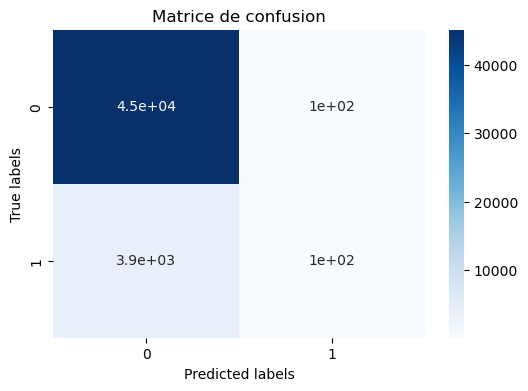

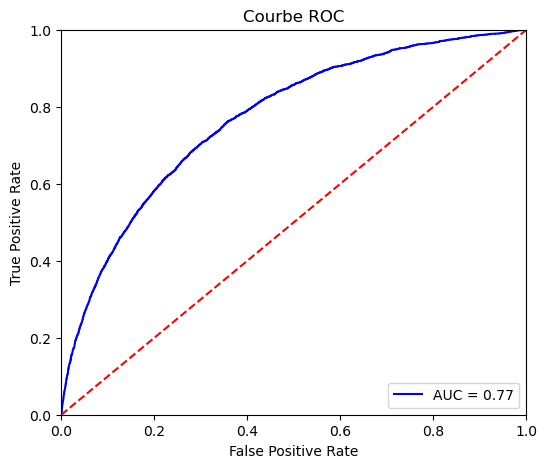

In [31]:
# Rééquilibrage avec Sous-échantillonnage (undersampling) de la classe majoritaire : Tomek Links

print('Equilibre des classes : {}'.format(Counter(y_train)))

# Création de l'objet TomekLinks
tomek_links = TomekLinks()

# Sous-échantillonnage en utilisant Tomek Links
X_train_tl, y_train_tl = tomek_links.fit_resample(X_train_scaled, y_train)

print('Equilibre des classes : {}'.format(Counter(y_train_tl)))


with mlflow.start_run(run_name='LogisticRegression undersampling'):
    reg_log_under = LogisticRegression(max_iter=1000, random_state=0)
    reg_log_under.fit(X_train_tl, y_train_tl)
    
    # Calcul et enregistrement des metriques sur les données de validation
    score_metier, accuracy, precision, recall, f1_score, fbeta_score, rocauc, y_pred_proba =\
    eval_score(reg_log_under, X_val_scaled, y_val)
   
    mlflow.log_metric("val_score_métier", score_metier)
    mlflow.log_metric("val_accuracy", accuracy)
    mlflow.log_metric("val_precision", precision)
    mlflow.log_metric("val_recall", recall)
    mlflow.log_metric("val_f1_score", f1_score)
    mlflow.log_metric("val_fbeta_score", fbeta_score)
    mlflow.log_metric("val_rocauc", rocauc)

## <a id="5.4.5">5.4.5  Rééquilibrage avec Sous-échantillonnage (undersampling) de la classe majoritaire : Tomek Links</a>

Equilibre des classes : Counter({0: 226145, 1: 19860})
Equilibre des classes : Counter({0: 19860, 1: 19860})


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Score métier :0.40
Accuracy score : 0.70
Precision score : 0.17
Recall score : 0.70
F1 score : 0.27
Fbeta score : 0.43
ROC AUC score : 0.70


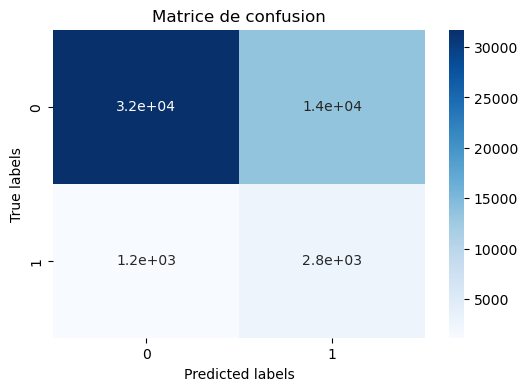

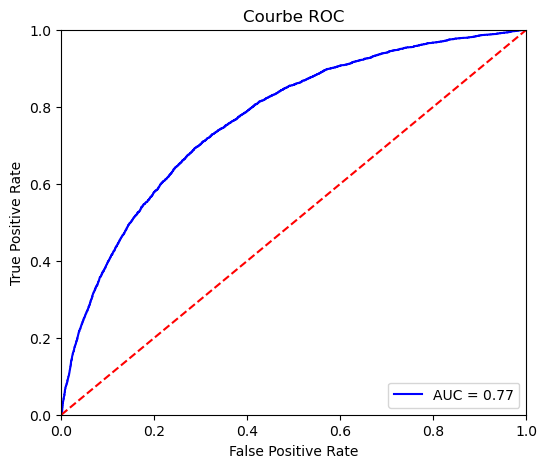

In [32]:
# Rééquilibrage avec Sous-échantillonnage (undersampling) de la classe majoritaire : RandomUnderSampler

print('Equilibre des classes : {}'.format(Counter(y_train)))

# Création de l'objet TomekLinks
under = RandomUnderSampler()

# Sous-échantillonnage en utilisant RandomUnderSampler
X_train_under, y_train_under = under.fit_resample(X_train_scaled, y_train)

print('Equilibre des classes : {}'.format(Counter(y_train_under)))


with mlflow.start_run(run_name='LogisticRegression undersampling Random'):
    reg_log_under_r = LogisticRegression(max_iter=1000, random_state=0)
    reg_log_under_r.fit(X_train_under, y_train_under)
    
    # Calcul et enregistrement des metriques sur les données de validation
    score_metier, accuracy, precision, recall, f1_score, fbeta_score, rocauc, y_pred_proba =\
    eval_score(reg_log_under_r, X_val_scaled, y_val)
   
    mlflow.log_metric("val_score_métier", score_metier)
    mlflow.log_metric("val_accuracy", accuracy)
    mlflow.log_metric("val_precision", precision)
    mlflow.log_metric("val_recall", recall)
    mlflow.log_metric("val_f1_score", f1_score)
    mlflow.log_metric("val_fbeta_score", fbeta_score)
    mlflow.log_metric("val_rocauc", rocauc)

# **RECAPITULATIFS EQILIBRAGE DES DONNEES**


- **Aucun rééquilibrage**
        - Score métier : 0.13
        - Accuracy score : 0.92.


- **Tomek link**  
        - Score métier : 0.13
        - Accuracy score : 0.92.


- **RandomUnderSampler**
        - Score métier : 0.40
        - Accuracy score : 0.70.


- **Class_weight**
        - Score métier : 0.41
        - Accuracy score : 0.71.


- **SMOTE** 
        - Score métier :0.13 
        - Accuracy score : 0.92.

Nous optons pour l'approche d'undersampling en utilisant **RandomUnderSampler** pour équilibrer nos données. Cette décision est motivée par les performances optimales observées avec les méthodes **class_weight et RandomUnderSampler**. Toutefois, il est important de noter que l'argument **class_weight n'est pas pris en charge par tous les modèles**. De plus, RandomUnderSampler présente l'avantage d'avoir des temps d'exécution considérablement plus courts par rapport à d'autres méthodes. Par conséquent, nous privilégions l'utilisation de RandomUnderSampler, ce qui nous permettra d'explorer un plus grand nombre de modèles dans un laps de temps raisonnable.

In [33]:
# enregistrer le df train rééquilibré 
pickle.dump(X_train_under, open('models/X_train_under.pkl', 'wb'))
pickle.dump(y_train_under, open('models/y_train_under.pkl', 'wb'))

In [34]:
X_train_scaled = pickle.load(open('models/X_train_under.pkl', 'rb'))
y_train = pickle.load(open('models/y_train_under.pkl', 'rb'))

## <a id="6"> 6. Application des modèles </a>

Nous allons tester ces differentes différents algorithmes : 

- **Dummy Classifier** : ne prend pas en compte les caractéristiques du jeu de données et se contente de faire des prédictions en utilisant des règles simples. Ici, on renvoie l'étiquette de classe la plus fréquente dans l'argument y observé.


- **Logistic Regression** : le but est de trouver une relation mathématique entre les variables d'entrée (features) et la variable de sortie (classe prédite). Cette relation est généralement exprimée sous la forme d'une fonction logistique qui transforme la sortie en une probabilité.


- **SVC**: L'algorithme fonctionne en trouvant un hyperplan optimal qui sépare les données d'entraînement en différentes classes. L'hyperplan est déterminé de manière à maximiser la marge entre les points de données de chaque classe. Les points de données les plus proches de l'hyperplan sont appelés vecteurs de support.


- **Decision Tree**: algorithme d'apprentissage automatique qui prend un ensemble de données en entrée et construit un modèle prédictif sous forme d'arbre hiérarchique. Chaque nœud de l'arbre représente une caractéristique de l'ensemble de données, chaque branche représente une règle de décision basée sur cette caractéristique, et chaque feuille représente une classe ou une valeur prédite.


- **Random Forest** : algorithme d'apprentissage automatique qui combine plusieurs arbres de décision pour effectuer des prédictions. Chaque arbre de la forêt donne une prédiction et la classe prédite est déterminée par un vote majoritaire.


- **XG Boost** : utilise un ensemble de modèles d'arbres de décision pour effectuer des prédictions. L'algorithme fonctionne en itérations successives pour minimiser une fonction de perte spécifiée et ajouter des arbres qui réduisent cette perte.


- **Light GBM** : algorithme d'apprentissage automatique basé sur le gradient boosting qui est conçu pour offrir une exécution rapide et des performances élevées. Il utilise une technique d'échantillonnage basée sur le gradient pour sélectionner les échantillons les plus informatifs pendant le processus d'apprentissage.

## <a id="6.1">6.1  Baseline: Dummy Classifier </a>

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Score métier :0.11
Accuracy score : 0.92
Precision score : 0.00
Recall score : 0.00
F1 score : 0.00
Fbeta score : 0.00
ROC AUC score : 0.50


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


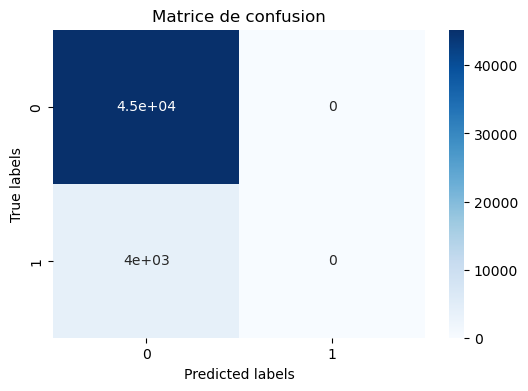

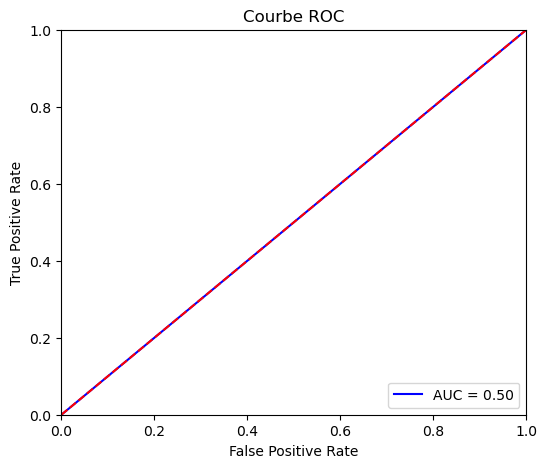

In [35]:
with mlflow.start_run(run_name='Dummy Classifier'):
    dummy = DummyClassifier(random_state=0)
    dummy.fit(X_train_scaled, y_train)
    
    # Calcul et enregistrement des metriques sur les données de validation
    score_metier, accuracy, precision, recall, f1_score, fbeta_score, rocauc, y_pred_proba =\
    eval_score(dummy, X_val_scaled, y_val)
   
    mlflow.log_metric("val_score_métier", score_metier)
    mlflow.log_metric("val_accuracy", accuracy)
    mlflow.log_metric("val_precision", precision)
    mlflow.log_metric("val_recall", recall)
    mlflow.log_metric("val_f1_score", f1_score)
    mlflow.log_metric("val_fbeta_score", fbeta_score)
    mlflow.log_metric("val_rocauc", rocauc)

Grâce à la matrice de confusion, on constate que le Dummy Classifier prédit bien seulement la classe 0 (client ne faisant pas défaut) et contient donc beaucoup de faux négatifs (mauvais client prédit bon client). C'est la raison pour laquelle il possède un score métier relativement faible (car ce dernier pénalise plus fortement les faux négatifs).

La plupart de nos scores sont à 0 puisque le modèle ne prédit aucune valeur positive. Les scores sont donc estimés à 0 puisque cela engendre une division par 0.

On constate que l'AUC est de 0.5 comme c'est le cas pour les modèles baseline.

Score métier maximum : 0.11
Threshold optimal : 0.5


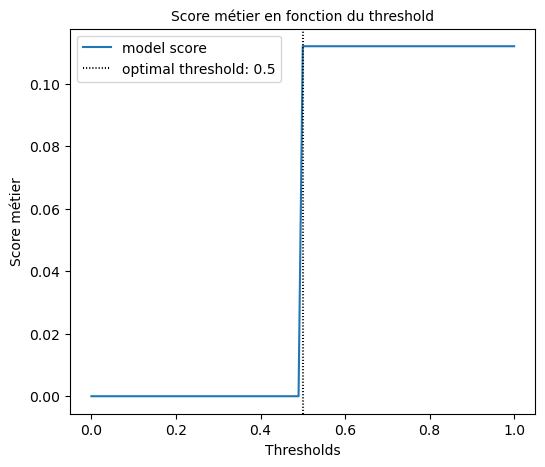

In [36]:
score_metier_max(y_pred_proba, y_val, verbose=True)

## <a id="6.2">6.2 Logistic Regression </a>

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Score métier :0.40
Accuracy score : 0.70
Precision score : 0.17
Recall score : 0.70
F1 score : 0.27
Fbeta score : 0.43
ROC AUC score : 0.70


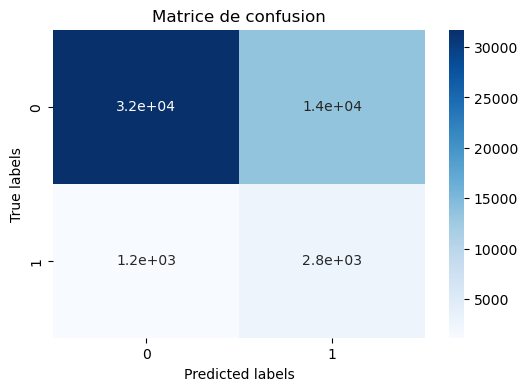

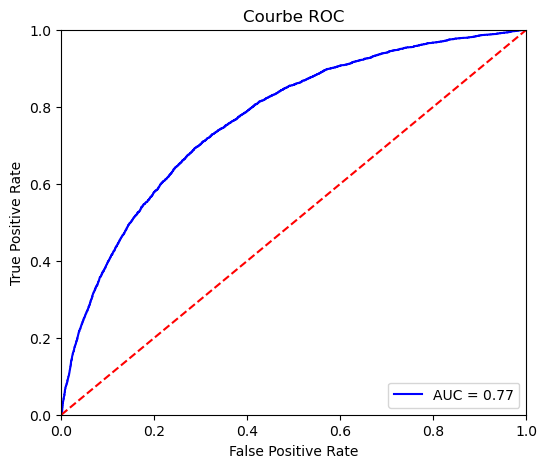

In [37]:
with mlflow.start_run(run_name='Logistic Regression'):
    reg_log = LogisticRegression(max_iter=1000, random_state=0)
    reg_log.fit(X_train_scaled, y_train)
    
    # Calcul et enregistrement des metriques sur les données de validation
    score_metier, accuracy, precision, recall, f1_score, fbeta_score, rocauc, y_pred_proba =\
    eval_score(reg_log, X_val_scaled, y_val)
   
    mlflow.log_metric("val_score_métier", score_metier)
    mlflow.log_metric("val_accuracy", accuracy)
    mlflow.log_metric("val_precision", precision)
    mlflow.log_metric("val_recall", recall)
    mlflow.log_metric("val_f1_score", f1_score)
    mlflow.log_metric("val_fbeta_score", fbeta_score)
    mlflow.log_metric("val_rocauc", rocauc)

Le score métier est nettement plus élevé à 0.40.

La matrice de confusion nous permet de constater que les FN sont présents en moins grande quantité que les autres catégories. Le modèle présente cependant une grande quantité de FP.

Le f-béta score est effectivement plus élevé que le f-score puisque le recall est plus élevé que la précision, ce score étant établit ici pour privilégier le recall à la précision. 

On constate que le score ROC AUC est amélioré par rapport à la baseline et est de 0.70.

Score métier maximum : 0.41
Threshold optimal : 0.52


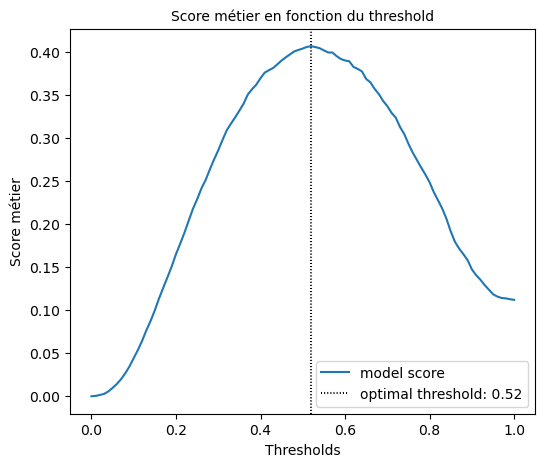

In [38]:
score_metier_max(y_pred_proba, y_val, verbose=True)

Le score métier semble optimal quand le seuil est fixé à 0.53, cependant l'augmentation est minime.

## <a id="6.2">6.3 SVC (Support Vector Classifier) </a>

Score métier :0.39
Accuracy score : 0.70
Precision score : 0.17
Recall score : 0.69
F1 score : 0.27
Fbeta score : 0.42
ROC AUC score : 0.69


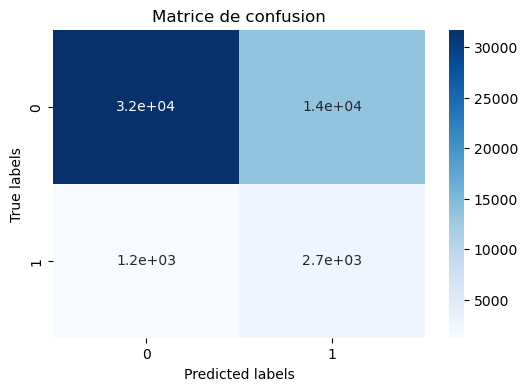

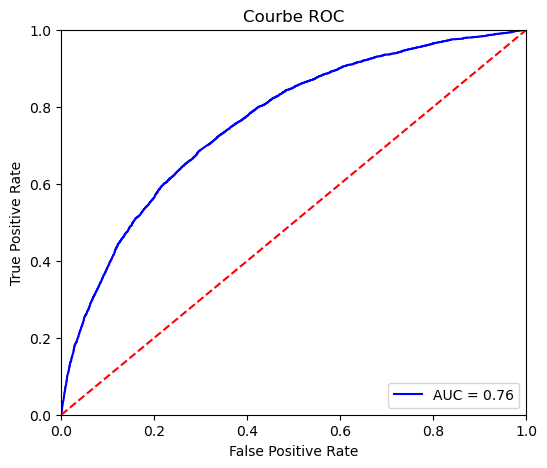

In [39]:
with mlflow.start_run(run_name='SVC'):
    svc = SVC(random_state=0, probability=True)
    svc.fit(X_train_scaled, y_train)
    
    # Calcul et enregistrement des metriques sur les données de validation
    score_metier, accuracy, precision, recall, f1_score, fbeta_score, rocauc, y_pred_proba =\
    eval_score(svc, X_val_scaled, y_val)
   
    mlflow.log_metric("val_score_métier", score_metier)
    mlflow.log_metric("val_accuracy", accuracy)
    mlflow.log_metric("val_precision", precision)
    mlflow.log_metric("val_recall", recall)
    mlflow.log_metric("val_f1_score", f1_score)
    mlflow.log_metric("val_fbeta_score", fbeta_score)
    mlflow.log_metric("val_rocauc", rocauc)

Le score métier est légèrement dégradé par rapport à la regression logistique à 0.39, mais bien supérieur à la baseline.

La matrice de confusion nous permet de constater que les FN sont présents en moins grande quantité que les autres catégories. Le modèle présente cependant une grande quantité de FP.

Le f-béta score est effectivement plus élevé que le f-score puisque le recall est plus élevé que la précision, ce score étant établit ici pour privilégier le recall à la précision.

On constate que le score ROC AUC est amélioré par rapport à la baseline et est de 0.69.

Score métier maximum : 0.39
Threshold optimal : 0.5700000000000001


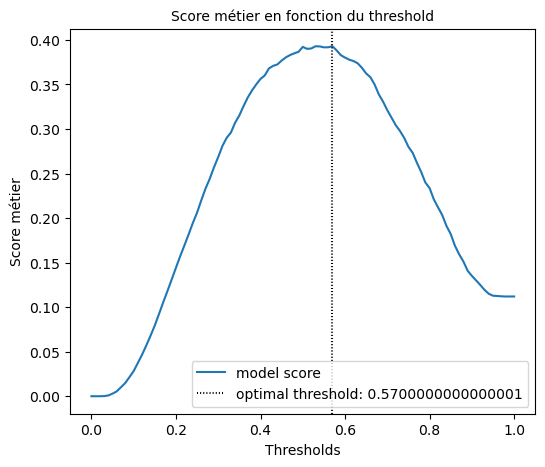

In [40]:
score_metier_max(y_pred_proba, y_val, verbose=True)

Le score métier semble optimal quand le seuil est fixé à 0.53, cependant l'augmentation est minime.

## <a id="6.4">6.4 Decision Tree</a>

Score métier :0.21
Accuracy score : 0.59
Precision score : 0.11
Recall score : 0.59
F1 score : 0.19
Fbeta score : 0.32
ROC AUC score : 0.59


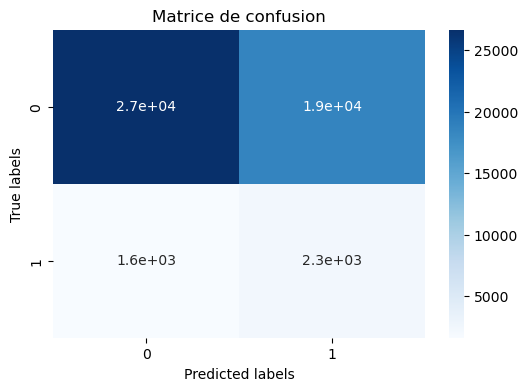

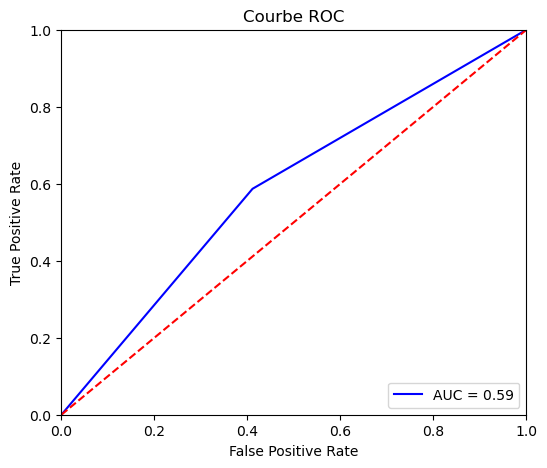

In [41]:
with mlflow.start_run(run_name='Decision Tree'):
    tree = DecisionTreeClassifier(random_state=0)
    tree.fit(X_train_scaled, y_train)
    
    # Calcul et enregistrement des metriques sur les données de validation
    score_metier, accuracy, precision, recall, f1_score, fbeta_score, rocauc, y_pred_proba =\
    eval_score(tree, X_val_scaled, y_val)
   
    mlflow.log_metric("val_score_métier", score_metier)
    mlflow.log_metric("val_accuracy", accuracy)
    mlflow.log_metric("val_precision", precision)
    mlflow.log_metric("val_recall", recall)
    mlflow.log_metric("val_f1_score", f1_score)
    mlflow.log_metric("val_fbeta_score", fbeta_score)
    mlflow.log_metric("val_rocauc", rocauc)

Le score métier est dégradé par rapport à la regression logistique à 0.21, mais reste plus élevé que la baseline.

La matrice de confusion nous permet de constater que les FN sont présents en moins grande quantité que les autres catégories. Le modèle présente cependant une grande quantité de FP.

Le f-béta score est effectivement plus élevé que le f-score puisque le recall est plus élevé que la précision, ce score étant établit ici pour privilégier le recall à la précision.

On constate que le score ROC AUC est légèrement amélioré par rapport à la baseline et est de 0.59.

Score métier maximum : 0.21
Threshold optimal : 0.0


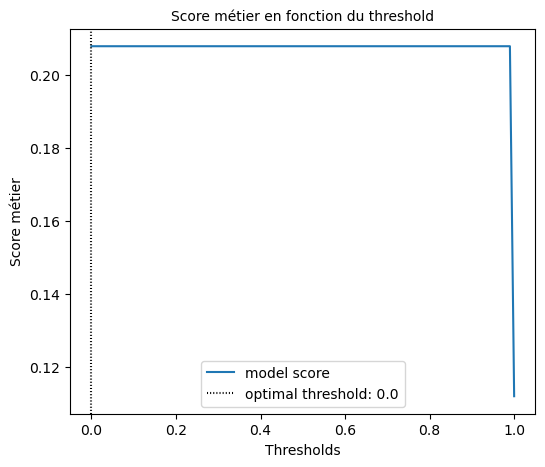

In [42]:
score_metier_max(y_pred_proba, y_val, verbose=True)

On constate que peu importe le seuil, le score métier reste le même avec ce modèle.

## <a id="6.5">6.5 Random Forest Classifier </a>

Score métier :0.37
Accuracy score : 0.69
Precision score : 0.16
Recall score : 0.67
F1 score : 0.26
Fbeta score : 0.41
ROC AUC score : 0.68


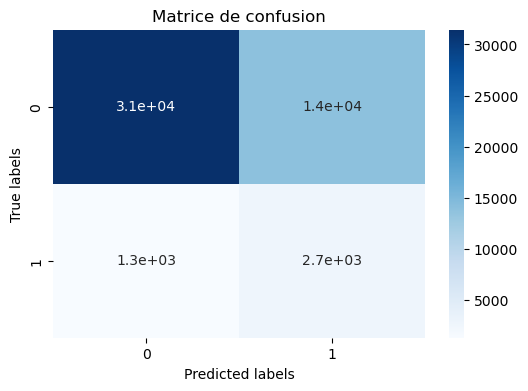

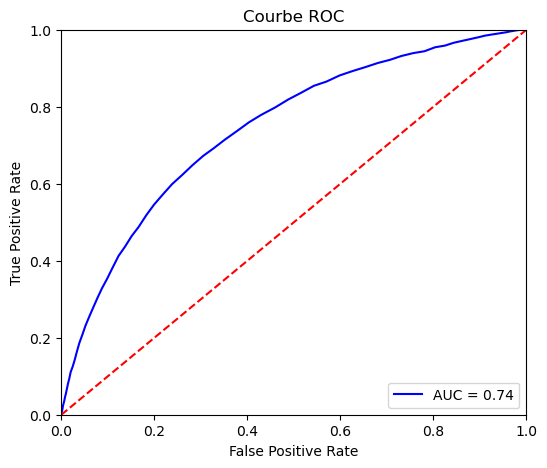

In [43]:
with mlflow.start_run(run_name='Random Forest'):
    rf = RandomForestClassifier(random_state=0)
    rf.fit(X_train_scaled, y_train)
    
    # Calcul et enregistrement des metriques sur les données de validation
    score_metier, accuracy, precision, recall, f1_score, fbeta_score, rocauc, y_pred_proba =\
    eval_score(rf, X_val_scaled, y_val)
   
    mlflow.log_metric("val_score_métier", score_metier)
    mlflow.log_metric("val_accuracy", accuracy)
    mlflow.log_metric("val_precision", precision)
    mlflow.log_metric("val_recall", recall)
    mlflow.log_metric("val_f1_score", f1_score)
    mlflow.log_metric("val_fbeta_score", fbeta_score)
    mlflow.log_metric("val_rocauc", rocauc)

Le score métier est légèrement dégradé par rapport à la regression logistique à 0.38.

La matrice de confusion nous permet de constater que les FN sont présents en moins grande quantité que les autres catégories. Le modèle présente cependant une grande quantité de FP.

Le f-béta score est effectivement plus élevé que le f-score puisque le recall est plus élevé que la précision, ce score étant établit ici pour privilégier le recall à la précision. 

On constate que le score ROC AUC est amélioré par rapport à la baseline et est de 0.69.

Score métier maximum : 0.38
Threshold optimal : 0.53


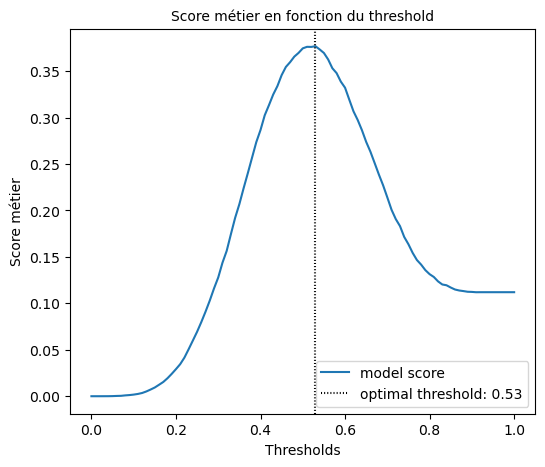

In [44]:
score_metier_max(y_pred_proba, y_val, verbose=True)

Le score métier semble optimal quand le seuil est fixé à 0.52, cependant l'augmentation est minime.

## <a id="6.6">6.6 XGBoost Classifier </a>

Score métier :0.40
Accuracy score : 0.69
Precision score : 0.17
Recall score : 0.70
F1 score : 0.27
Fbeta score : 0.43
ROC AUC score : 0.70


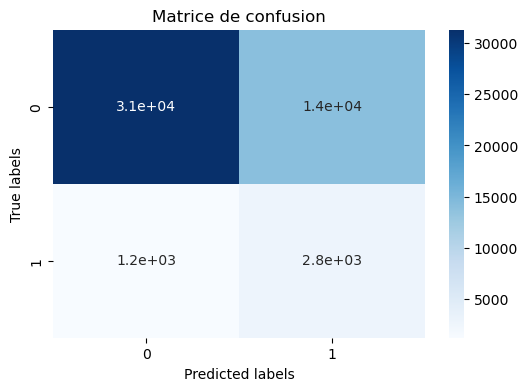

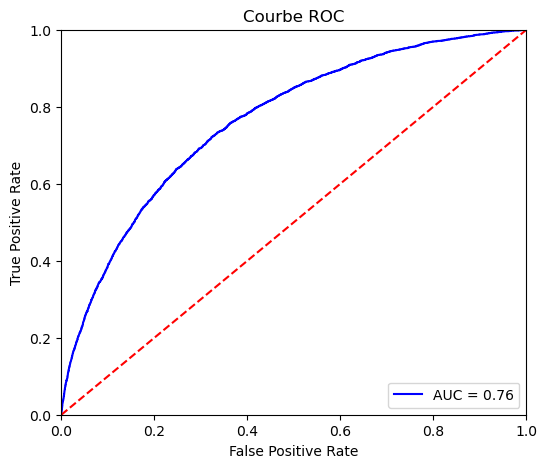

In [45]:
with mlflow.start_run(run_name='XGBoost Classifier'):
    xgb = XGBClassifier(random_state=0)
    xgb.fit(X_train_scaled, y_train)
    
    # Calcul et enregistrement des metriques sur les données de validation
    score_metier, accuracy, precision, recall, f1_score, fbeta_score, rocauc, y_pred_proba =\
    eval_score(xgb, X_val_scaled, y_val)
   
    mlflow.log_metric("val_score_métier", score_metier)
    mlflow.log_metric("val_accuracy", accuracy)
    mlflow.log_metric("val_precision", precision)
    mlflow.log_metric("val_recall", recall)
    mlflow.log_metric("val_f1_score", f1_score)
    mlflow.log_metric("val_fbeta_score", fbeta_score)
    mlflow.log_metric("val_rocauc", rocauc)

Le score métier est légèrement plus élevé par rapport à Random Forest à 0.39.

La matrice de confusion nous permet de constater que les FN sont présents en moins grande quantité que les autres catégories. Le modèle présente cependant une grande quantité de FP.

Le f-béta score est effectivement plus élevé que le f-score puisque le recall est plus élevé que la précision, ce score étant établit ici pour privilégier le recall à la précision. 

On constate que le score ROC AUC est amélioré par rapport à la baseline et est de 0.70.

Score métier maximum : 0.40
Threshold optimal : 0.51


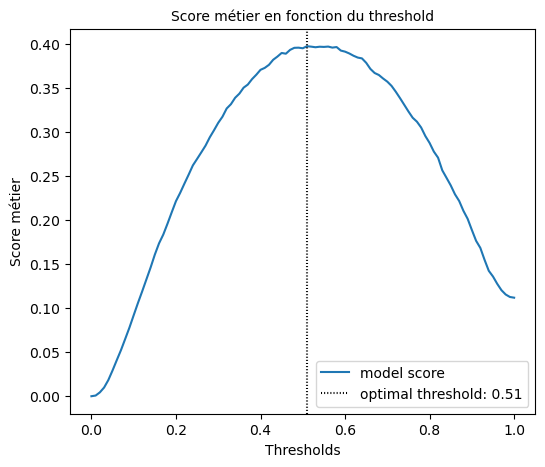

In [46]:
score_metier_max(y_pred_proba, y_val, verbose=True)

Le score métier semble optimal quand le seuil est fixé à 0.55.

## <a id="6.7">6.7 Light GBM </a>

Score métier :0.41
Accuracy score : 0.70
Precision score : 0.17
Recall score : 0.70
F1 score : 0.28
Fbeta score : 0.44
ROC AUC score : 0.70


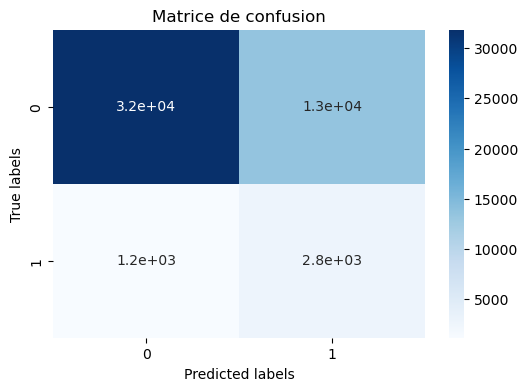

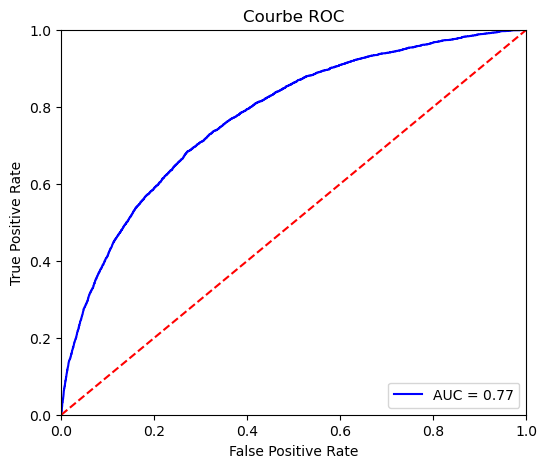

In [47]:
with mlflow.start_run(run_name='LGBM Classifier'):
    lgbm = LGBMClassifier(random_state=0)
    lgbm.fit(X_train_scaled, y_train)
    
    # Calcul et enregistrement des metriques sur les données de validation
    score_metier, accuracy, precision, recall, f1_score, fbeta_score, rocauc, y_pred_proba =\
    eval_score(lgbm, X_val_scaled, y_val)
   
    mlflow.log_metric("val_score_métier", score_metier)
    mlflow.log_metric("val_accuracy", accuracy)
    mlflow.log_metric("val_precision", precision)
    mlflow.log_metric("val_recall", recall)
    mlflow.log_metric("val_f1_score", f1_score)
    mlflow.log_metric("val_fbeta_score", fbeta_score)
    mlflow.log_metric("val_rocauc", rocauc)

Le score métier est légèrement plus élevé par rapport à XGBoots à 0.41.

La matrice de confusion nous permet de constater que les FN sont présents en moins grande quantité que les autres catégories. Le modèle présente cependant une grande quantité de FP.

Le f-béta score est effectivement plus élevé que le f-score puisque le recall est plus élevé que la précision, ce score étant établit ici pour privilégier le recall à la précision. 

On constate que le score ROC AUC est amélioré par rapport à la baseline et est de 0.71.

Score métier maximum : 0.41
Threshold optimal : 0.52


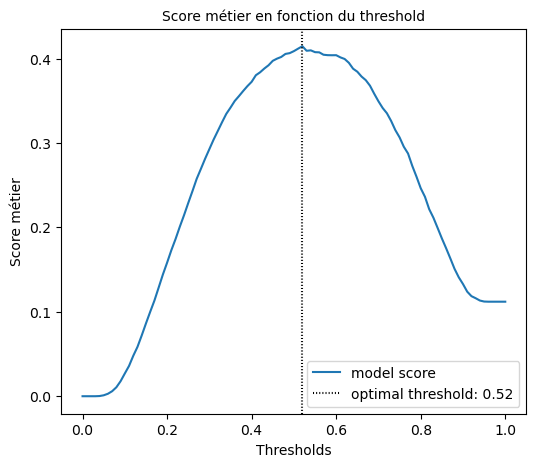

In [48]:
score_metier_max(y_pred_proba, y_val, verbose=True)

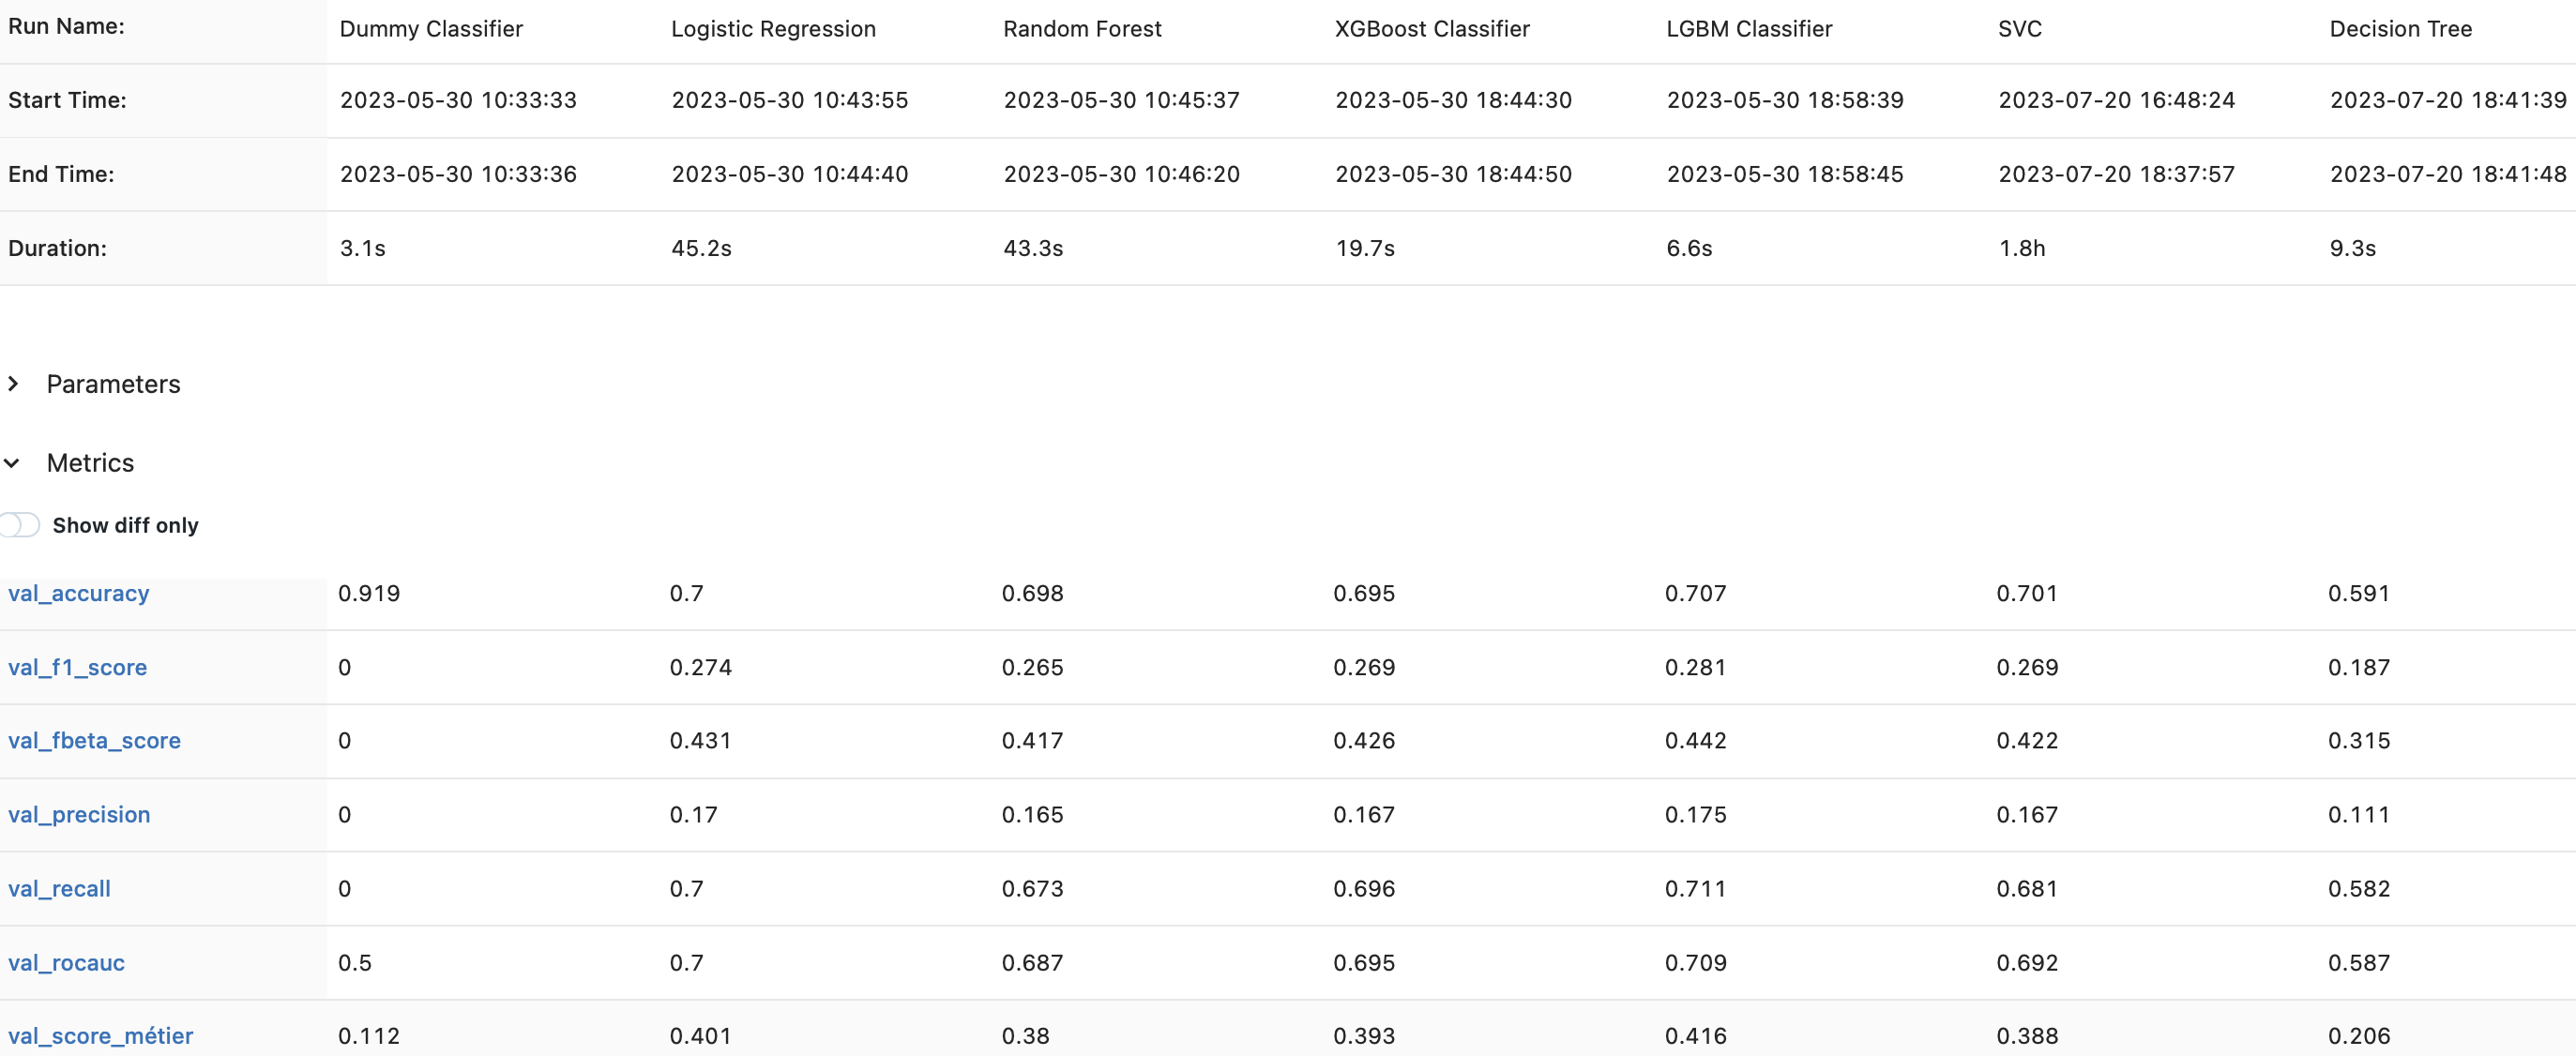

Pour le moment on peut constater que LightGBM présente le meilleur score métier (0.42) suivi par la regression logistique avec un score de 0.40. 

Les courbes du score métier en fonction du seuil on été tracé et on constate que les meilleurs seuils se situent tous autour de 0.5 puisque le dataset que nous utilisons est équilibré.

Nous allons désormais optimiser nos modèles en testant différents hyperparamètres.

## <a id="7"> 7. Optimisation des modèles </a>

## <a id="7.1"> 7.1  Logistic Regression

In [49]:
score_metier = metrics.make_scorer(fonction_metier, greater_is_better=True)

In [50]:
score_metier

make_scorer(fonction_metier)

In [51]:
# params = {'penalty':['l1', 'l2', 'elasticnet'],
#           'C':[1e-5, 1e-2, 1, 10, 100],
#           'solver':['newton-cg', 'lbfgs', 'liblinear']
#          }
params = {'penalty': ['l2'],  # Utiliser seulement les pénalités compatibles avec 'newton-cg'
          'C': [1e-5, 1e-2, 1, 10, 100],
          'solver': ['newton-cg', 'lbfgs', 'liblinear']
         }

# Le reste de votre code reste inchangé

with mlflow.start_run(run_name='Grid logistic regression'):
    reg_log = LogisticRegression(max_iter=1000, random_state=0)
    grid_reg_log = GridSearchCV(
        reg_log,
        param_grid=params,
        cv=5,
        scoring=score_metier,
        return_train_score = True,
        n_jobs = -1,
        error_score='raise'
       )
    
    grid_reg_log.fit(X_train_scaled, y_train)

In [52]:
result_reg_log = pd.DataFrame(grid_reg_log.cv_results_)

In [53]:
print('Meilleurs paramètres',grid_reg_log.best_params_)
print("Résultats des meilleurs paramètres :\n")
display(result_reg_log.loc[result_reg_log['params']==grid_reg_log.best_params_])

Meilleurs paramètres {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Résultats des meilleurs paramètres :



mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
11      233.31652      7.206201         0.059715        0.008254      10   

   param_penalty param_solver  \
11            l2    liblinear   

                                               params  split0_test_score  \
11  {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}          -1.188318   

    split1_test_score  split2_test_score  split3_test_score  \
11          -1.114804          -1.178877          -1.167296   

    split4_test_score  mean_test_score  std_test_score  rank_test_score  \
11          -1.146777        -1.159215        0.026176                1   

    split0_train_score  split1_train_score  split2_train_score  \
11           -1.083837           -1.093593           -1.079085   

    split3_train_score  split4_train_score  mean_train_score  std_train_score  
11           -1.086449           -1.115118         -1.091616         0.012653

In [54]:
def plot_learning_curve(estimator, X, y):
    '''Affiche la courbe d'apprentissage.
    :param: estimator (meilleur estiateur de la grid search), X (valeurs), y (target)    
    '''
    
    train_sizes, train_scores, test_scores = learning_curve(estimator=estimator, X=X, y=y, cv=5, 
                                                            train_sizes=np.linspace(0.1, 1.0, 10),
                                                            n_jobs= -1, verbose=0)
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Score')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
    plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Score')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
    plt.title('Learning Curve')
    plt.xlabel('Training Data Size')
    plt.ylabel('Performance score métier')
    plt.grid()
    plt.legend(loc='lower right')
    plt.show()

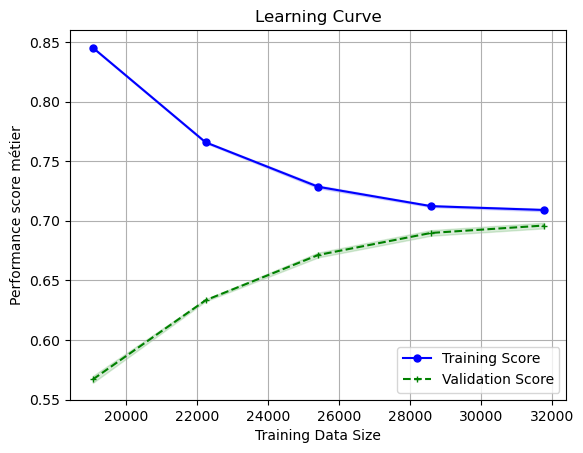

In [55]:
plot_learning_curve(grid_reg_log.best_estimator_, X_train_scaled, y_train)

Score métier :0.41
Accuracy score : 0.70
Precision score : 0.17
Recall score : 0.70
F1 score : 0.28
Fbeta score : 0.43
ROC AUC score : 0.70


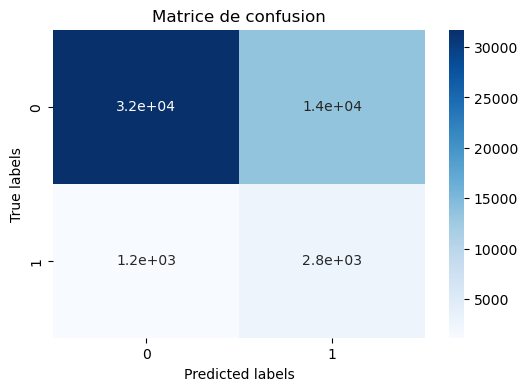

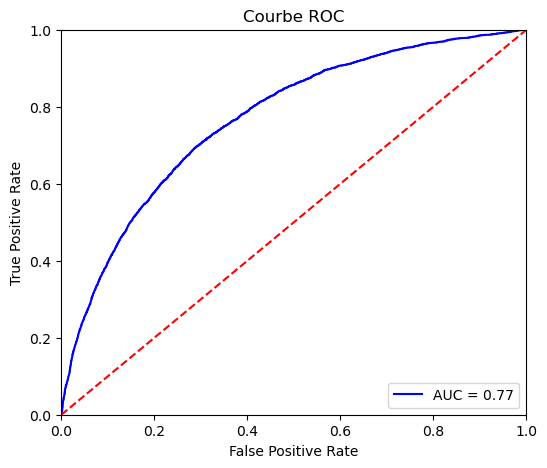

In [56]:
with mlflow.start_run(run_name='Logistic regression optimise'):
    # Calcul et enregistrement des metriques sur les données de validation
    score_metier, accuracy, precision, recall, f1_score, fbeta_score, rocauc, y_pred_proba =\
    eval_score(grid_reg_log, X_val_scaled, y_val)
   
    mlflow.log_metric("val_score_métier", score_metier)
    mlflow.log_metric("val_accuracy", accuracy)
    mlflow.log_metric("val_precision", precision)
    mlflow.log_metric("val_recall", recall)
    mlflow.log_metric("val_f1_score", f1_score)
    mlflow.log_metric("val_fbeta_score", fbeta_score)
    mlflow.log_metric("val_rocauc", rocauc)

Score métier maximum : 0.41
Threshold optimal : 0.51


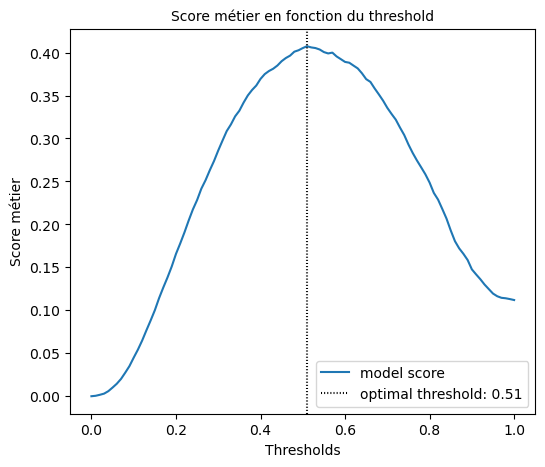

In [57]:
score_metier_max(y_pred_proba, y_val, verbose=True)

Après optimisation des hyperparamètres, nous obtenons un score métier à 0.41, ce qui ne change pas par rapport au modèle de base. Les hyperparamètres optimaux ne semblent pas avoir d'impact significatifs sur les performances de notre modèle.

## <a id="7.2"> 7.2  SVC (Support Vector Machine) </a>

In [58]:
import random
random.seed(0)

In [59]:
X_train_scaled.shape

(39720, 559)

In [60]:
X_train_sample = X_train_scaled.sample(n=10000,axis=0)
y_train_sample = y_train[X_train_sample.index]

In [61]:
print(X_train_sample.shape)
print(y_train_sample.shape)

(10000, 559)
(10000,)


In [62]:
from sklearn.metrics import make_scorer
# Convertir la fonction score_metier en un scorer compatible
# scorer = make_scorer(score_metier)
params = {'C':[1e-3, 1, 10],'kernel':['linear', 'rbf']}

with mlflow.start_run(run_name='Grid SVC'):
    svc = SVC(random_state=0, probability=True)
    grid_svc = GridSearchCV(
        svc,
        param_grid=params,
        cv=5,
        scoring=make_scorer(score_metier),
        return_train_score = True,
        n_jobs = -1)
    
    grid_svc.fit(X_train_sample, y_train_sample)

In [63]:
result_svc = pd.DataFrame(grid_svc.cv_results_)

In [64]:
print('Meilleurs paramètres',grid_svc.best_params_)
print("Résultats des meilleurs paramètres :\n")
display(result_svc.loc[result_svc['params']==grid_svc.best_params_])

Meilleurs paramètres {'C': 0.001, 'kernel': 'linear'}
Résultats des meilleurs paramètres :



mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0     425.428374      1.341241        16.012815        0.129368   0.001   

  param_kernel                            params  split0_test_score  \
0       linear  {'C': 0.001, 'kernel': 'linear'}                NaN   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0                NaN                NaN                NaN                NaN   

   mean_test_score  std_test_score  rank_test_score  split0_train_score  \
0              NaN             NaN      -2147483648                 NaN   

   split1_train_score  split2_train_score  split3_train_score  \
0                 NaN                 NaN                 NaN   

   split4_train_score  mean_train_score  std_train_score  
0                 NaN               NaN              NaN

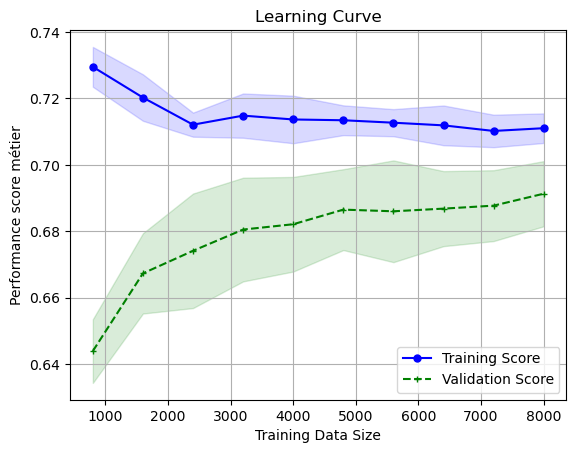

In [65]:
plot_learning_curve(grid_svc.best_estimator_, X_train_sample, y_train_sample)

Score métier :0.38
Accuracy score : 0.70
Precision score : 0.16
Recall score : 0.67
F1 score : 0.26
Fbeta score : 0.42
ROC AUC score : 0.69


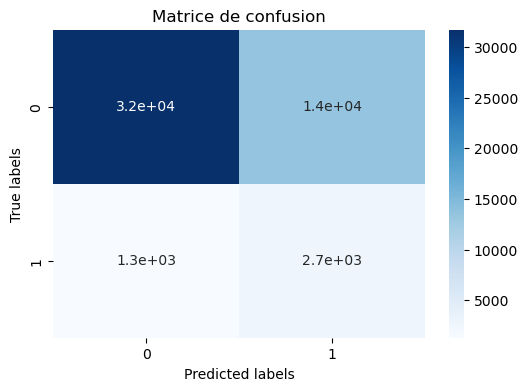

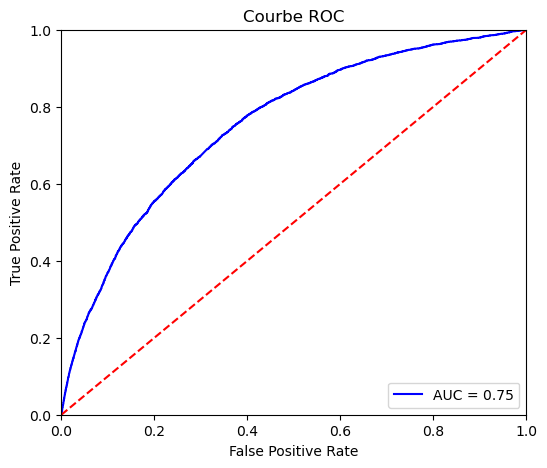

In [66]:
with mlflow.start_run(run_name='SVC optimise'):
    # Calcul et enregistrement des metriques sur les données de validation
    score_metier, accuracy, precision, recall, f1_score, fbeta_score, rocauc, y_pred_proba =\
    eval_score(grid_svc, X_val_scaled, y_val)
   
    mlflow.log_metric("val_score_métier", score_metier)
    mlflow.log_metric("val_accuracy", accuracy)
    mlflow.log_metric("val_precision", precision)
    mlflow.log_metric("val_recall", recall)
    mlflow.log_metric("val_f1_score", f1_score)
    mlflow.log_metric("val_fbeta_score", fbeta_score)
    mlflow.log_metric("val_rocauc", rocauc)

Score métier maximum : 0.38
Threshold optimal : 0.55


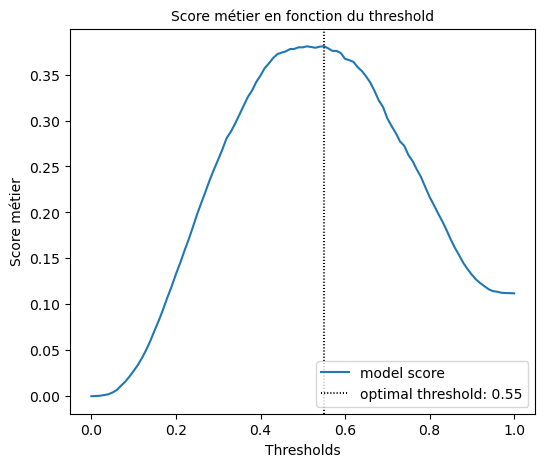

In [67]:
score_metier_max(y_pred_proba, y_val, verbose=True)

Après optimisation des hyperparamètres, nous obtenons un score métier à 0.39.

## <a id="7.3"> 7.3  Decision Tree </a>

In [68]:
params =  {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [2, 5, 10, None]
}


with mlflow.start_run(run_name='Grid Decision Tree'):
    tree = DecisionTreeClassifier(random_state=0)
    grid_tree = GridSearchCV(
        tree,
        param_grid=params,
        cv=5,
        scoring=make_scorer(score_metier),
        return_train_score = True,
        n_jobs = -1)
    
    grid_tree.fit(X_train_scaled, y_train)

In [69]:
result_tree = pd.DataFrame(grid_tree.cv_results_)

In [70]:
print('Meilleurs paramètres',grid_tree.best_params_)
print("Résultats des meilleurs paramètres :\n")
display(result_tree.loc[result_tree['params']==grid_tree.best_params_])

Meilleurs paramètres {'criterion': 'gini', 'max_depth': 2}
Résultats des meilleurs paramètres :



mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        1.55005       0.00775         0.088772        0.020981   

  param_criterion param_max_depth                                 params  \
0            gini               2  {'criterion': 'gini', 'max_depth': 2}   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
0                NaN                NaN                NaN                NaN   

   split4_test_score  mean_test_score  std_test_score  rank_test_score  \
0                NaN              NaN             NaN      -2147483648   

   split0_train_score  split1_train_score  split2_train_score  \
0                 NaN                 NaN                 NaN   

   split3_train_score  split4_train_score  mean_train_score  std_train_score  
0                 NaN                 NaN               NaN              NaN

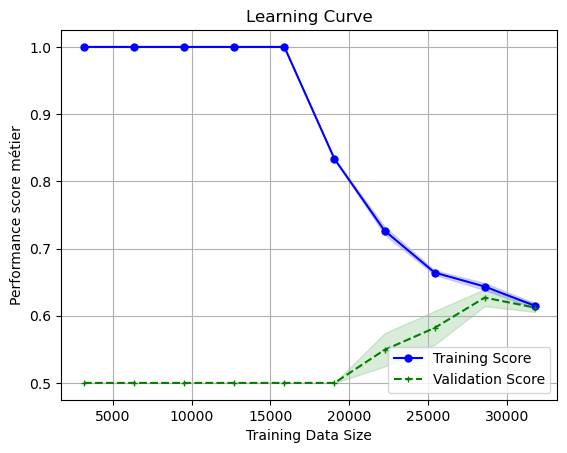

In [71]:
plot_learning_curve(grid_tree.best_estimator_, X_train_scaled, y_train)

Score métier :0.27
Accuracy score : 0.75
Precision score : 0.15
Recall score : 0.46
F1 score : 0.23
Fbeta score : 0.33
ROC AUC score : 0.62


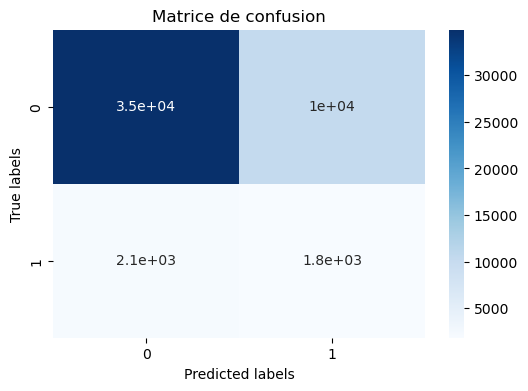

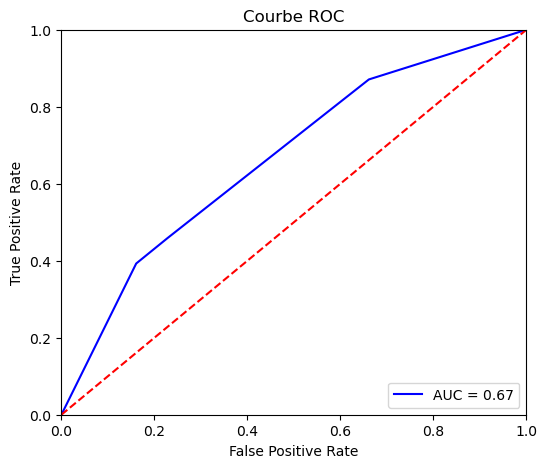

In [72]:
with mlflow.start_run(run_name='Decision Tree optimise'):
    # Calcul et enregistrement des metriques sur les données de validation
    score_metier, accuracy, precision, recall, f1_score, fbeta_score, rocauc, y_pred_proba =\
    eval_score(grid_tree, X_val_scaled, y_val)
   
    mlflow.log_metric("val_score_métier", score_metier)
    mlflow.log_metric("val_accuracy", accuracy)
    mlflow.log_metric("val_precision", precision)
    mlflow.log_metric("val_recall", recall)
    mlflow.log_metric("val_f1_score", f1_score)
    mlflow.log_metric("val_fbeta_score", fbeta_score)
    mlflow.log_metric("val_rocauc", rocauc)

Score métier maximum : 0.28
Threshold optimal : 0.51


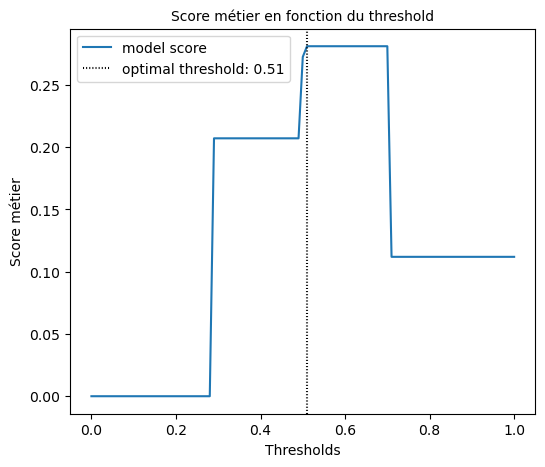

In [73]:
score_metier_max(y_pred_proba, y_val, verbose=True)

Après optimisation des hyperparamètres, nous obtenons un score métier à 0.31, qui est plus élevé que celui du modèle de base.

## <a id="7.4"> 7.4  Random Forest Classifier </a>

In [74]:
params = {'n_estimators' : [100, 500, 1000, 2000],
          'max_depth': [2, 5, 10, None],
         }

with mlflow.start_run(run_name='Grid random forest'):
    rand_fo = RandomForestClassifier(random_state=0)
    grid_rand_fo = GridSearchCV(
        rand_fo,
        param_grid=params,
        cv=5,
        scoring=make_scorer(score_metier),
        return_train_score = True,
        n_jobs = -1)
    
    grid_rand_fo.fit(X_train_scaled, y_train)

In [75]:
result_rand_fo = pd.DataFrame(grid_rand_fo.cv_results_)
result_rand_fo.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       3.985300      0.017532         0.118087        0.010899   
1      18.053496      0.076533         0.367616        0.017781   
2      36.016962      0.049160         0.677593        0.039642   
3      73.183593      0.765081         1.342247        0.061516   
4       9.072539      0.108985         0.136397        0.005430   

  param_max_depth param_n_estimators                                  params  \
0               2                100   {'max_depth': 2, 'n_estimators': 100}   
1               2                500   {'max_depth': 2, 'n_estimators': 500}   
2               2               1000  {'max_depth': 2, 'n_estimators': 1000}   
3               2               2000  {'max_depth': 2, 'n_estimators': 2000}   
4               5                100   {'max_depth': 5, 'n_estimators': 100}   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
0                NaN                NaN                NaN                NaN   
1                NaN                NaN                NaN                NaN   
2                NaN                NaN                NaN                NaN   
3                NaN                NaN                NaN                NaN   
4                NaN                NaN                NaN                NaN   

   split4_test_score  mean_test_score  std_test_score  rank_test_score  \
0                NaN              NaN             NaN      -2147483648   
1                NaN              NaN             NaN      -2147483648   
2                NaN              NaN             NaN      -2147483648   
3                NaN              NaN             NaN      -2147483648   
4                NaN              NaN             NaN      -2147483648   

   split0_train_score  split1_train_score  split2_train_score  \
0                 NaN                 NaN                 NaN   
1                 NaN                 NaN                 NaN   
2                 NaN                 NaN                 NaN   
3                 NaN                 NaN                 NaN   
4                 NaN                 NaN                 NaN   

   split3_train_score  split4_train_score  mean_train_score  std_train_score  
0                 NaN                 NaN               NaN              NaN  
1                 NaN                 NaN               NaN              NaN  
2                 NaN                 NaN               NaN              NaN  
3                 NaN                 NaN               NaN              NaN  
4                 NaN                 NaN               NaN              NaN

In [76]:
print('Meilleurs paramètres',grid_rand_fo.best_params_)
print("Résultats des meilleurs paramètres :\n")
display(result_rand_fo.loc[result_rand_fo['params']==grid_rand_fo.best_params_])

Meilleurs paramètres {'max_depth': 2, 'n_estimators': 100}
Résultats des meilleurs paramètres :



mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         3.9853      0.017532         0.118087        0.010899   

  param_max_depth param_n_estimators                                 params  \
0               2                100  {'max_depth': 2, 'n_estimators': 100}   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
0                NaN                NaN                NaN                NaN   

   split4_test_score  mean_test_score  std_test_score  rank_test_score  \
0                NaN              NaN             NaN      -2147483648   

   split0_train_score  split1_train_score  split2_train_score  \
0                 NaN                 NaN                 NaN   

   split3_train_score  split4_train_score  mean_train_score  std_train_score  
0                 NaN                 NaN               NaN              NaN

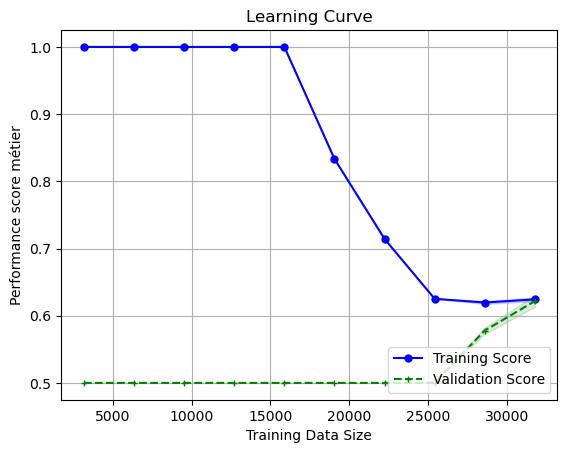

In [77]:
plot_learning_curve(grid_rand_fo.best_estimator_, X_train_scaled, y_train)

Score métier :0.27
Accuracy score : 0.62
Precision score : 0.13
Recall score : 0.63
F1 score : 0.21
Fbeta score : 0.35
ROC AUC score : 0.62


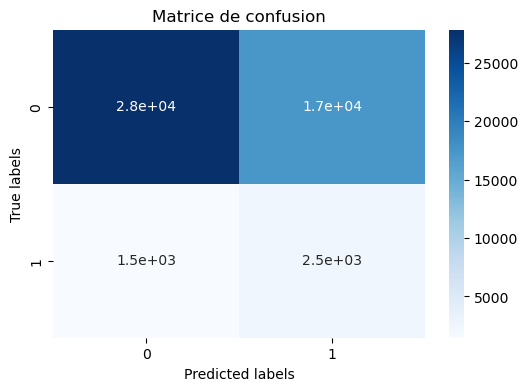

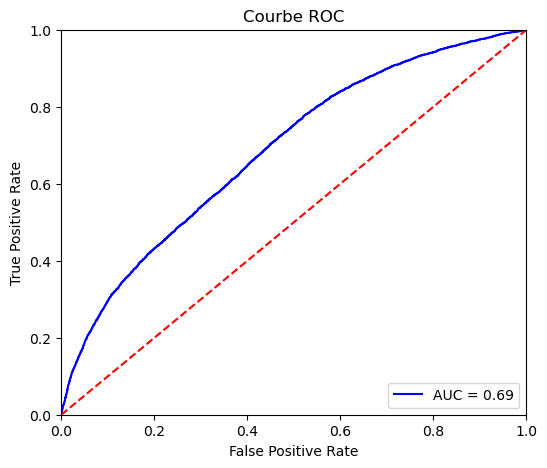

In [78]:
with mlflow.start_run(run_name='Random forest optimise'):
    # Calcul et enregistrement des metriques sur les données de validation
    score_metier, accuracy, precision, recall, f1_score, fbeta_score, rocauc, y_pred_proba =\
    eval_score(grid_rand_fo, X_val_scaled, y_val)
   
    mlflow.log_metric("val_score_métier", score_metier)
    mlflow.log_metric("val_accuracy", accuracy)
    mlflow.log_metric("val_precision", precision)
    mlflow.log_metric("val_recall", recall)
    mlflow.log_metric("val_f1_score", f1_score)
    mlflow.log_metric("val_fbeta_score", fbeta_score)
    mlflow.log_metric("val_rocauc", rocauc)

Score métier maximum : 0.28
Threshold optimal : 0.53


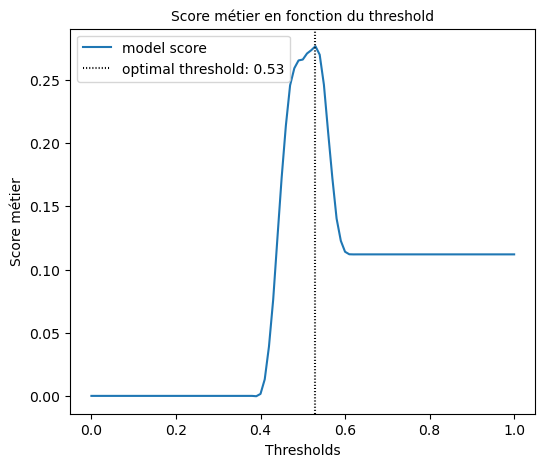

In [79]:
score_metier_max(y_pred_proba, y_val, verbose=True)

Après optimisation des hyperparamètres, nous obtenons un score métier à 0.28

## <a id="7.5"> 7.5 XGBoost Classifier </a>

In [80]:
params = {'gamma': [0, 0.1, 0.5, 1],
          'max_depth': [2,4,6],
          'min_child_weight' : [1,5,10],
          'n_estimators': [100, 300, 500],
         }

with mlflow.start_run(run_name='Grid XGBoost'):
    xgb = XGBClassifier(random_state=0)
    grid_xgb = GridSearchCV(
        xgb,
        param_grid=params,
        cv=5,
        scoring=make_scorer(score_metier),
        return_train_score = True,
        n_jobs = -1)
    
    grid_xgb.fit(X_train_scaled, y_train)

In [81]:
result_xgb = pd.DataFrame(grid_xgb.cv_results_)
result_xgb.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_gamma  \
0      46.263642      0.200772         0.099248        0.005505           0   
1     144.372479      0.717603         0.198414        0.010820           0   
2     243.723287      2.791358         0.126082        0.011085           0   
3      51.982625      1.633240         0.117966        0.025464           0   
4     146.690609      1.141822         0.108775        0.007917           0   

  param_max_depth param_min_child_weight param_n_estimators  \
0               2                      1                100   
1               2                      1                300   
2               2                      1                500   
3               2                      5                100   
4               2                      5                300   

                                              params  split0_test_score  \
0  {'gamma': 0, 'max_depth': 2, 'min_child_weight...                NaN   
1  {'gamma': 0, 'max_depth': 2, 'min_child_weight...                NaN   
2  {'gamma': 0, 'max_depth': 2, 'min_child_weight...                NaN   
3  {'gamma': 0, 'max_depth': 2, 'min_child_weight...                NaN   
4  {'gamma': 0, 'max_depth': 2, 'min_child_weight...                NaN   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0                NaN                NaN                NaN                NaN   
1                NaN                NaN                NaN                NaN   
2                NaN                NaN                NaN                NaN   
3                NaN                NaN                NaN                NaN   
4                NaN                NaN                NaN                NaN   

   mean_test_score  std_test_score  rank_test_score  split0_train_score  \
0              NaN             NaN      -2147483648                 NaN   
1              NaN             NaN      -2147483648                 NaN   
2              NaN             NaN      -2147483648                 NaN   
3              NaN             NaN      -2147483648                 NaN   
4              NaN             NaN      -2147483648                 NaN   

   split1_train_score  split2_train_score  split3_train_score  \
0                 NaN                 NaN                 NaN   
1                 NaN                 NaN                 NaN   
2                 NaN                 NaN                 NaN   
3                 NaN                 NaN                 NaN   
4                 NaN                 NaN                 NaN   

   split4_train_score  mean_train_score  std_train_score  
0                 NaN               NaN              NaN  
1                 NaN               NaN              NaN  
2                 NaN               NaN              NaN  
3                 NaN               NaN              NaN  
4                 NaN               NaN              NaN

In [82]:
print('Meilleurs paramètres',grid_xgb.best_params_)
print("Résultats des meilleurs paramètres :\n")
display(result_xgb.loc[result_xgb['params']==grid_xgb.best_params_])

Meilleurs paramètres {'gamma': 0, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 100}
Résultats des meilleurs paramètres :



mean_fit_time  std_fit_time  mean_score_time  std_score_time param_gamma  \
0      46.263642      0.200772         0.099248        0.005505           0   

  param_max_depth param_min_child_weight param_n_estimators  \
0               2                      1                100   

                                              params  split0_test_score  \
0  {'gamma': 0, 'max_depth': 2, 'min_child_weight...                NaN   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0                NaN                NaN                NaN                NaN   

   mean_test_score  std_test_score  rank_test_score  split0_train_score  \
0              NaN             NaN      -2147483648                 NaN   

   split1_train_score  split2_train_score  split3_train_score  \
0                 NaN                 NaN                 NaN   

   split4_train_score  mean_train_score  std_train_score  
0                 NaN               NaN              NaN

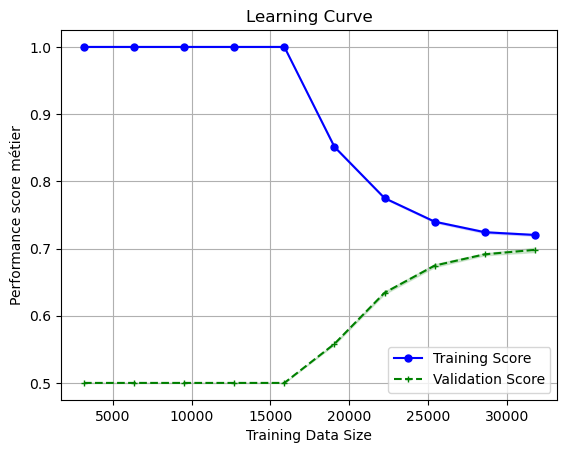

In [83]:
plot_learning_curve(grid_xgb.best_estimator_, X_train_scaled, y_train)

Score métier :0.41
Accuracy score : 0.71
Precision score : 0.17
Recall score : 0.70
F1 score : 0.28
Fbeta score : 0.44
ROC AUC score : 0.71


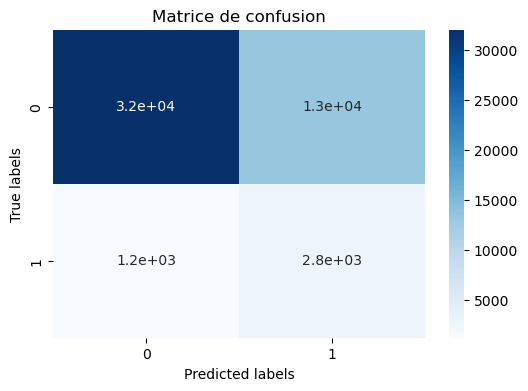

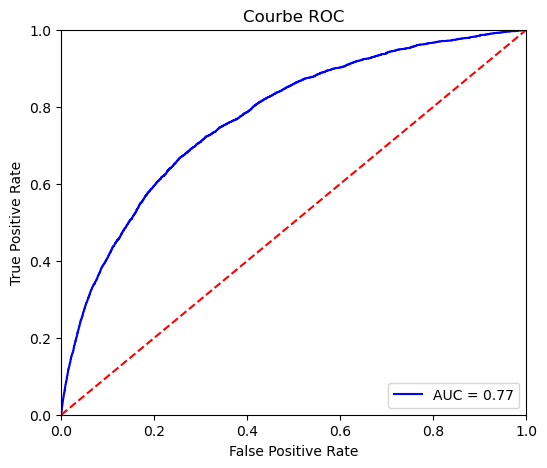

In [84]:
with mlflow.start_run(run_name='XGBoost optimise'):
    # Calcul et enregistrement des metriques sur les données de validation
    score_metier, accuracy, precision, recall, f1_score, fbeta_score, rocauc, y_pred_proba =\
    eval_score(grid_xgb, X_val_scaled, y_val)
   
    mlflow.log_metric("val_score_métier", score_metier)
    mlflow.log_metric("val_accuracy", accuracy)
    mlflow.log_metric("val_precision", precision)
    mlflow.log_metric("val_recall", recall)
    mlflow.log_metric("val_f1_score", f1_score)
    mlflow.log_metric("val_fbeta_score", fbeta_score)
    mlflow.log_metric("val_rocauc", rocauc)

Score métier maximum : 0.42
Threshold optimal : 0.53


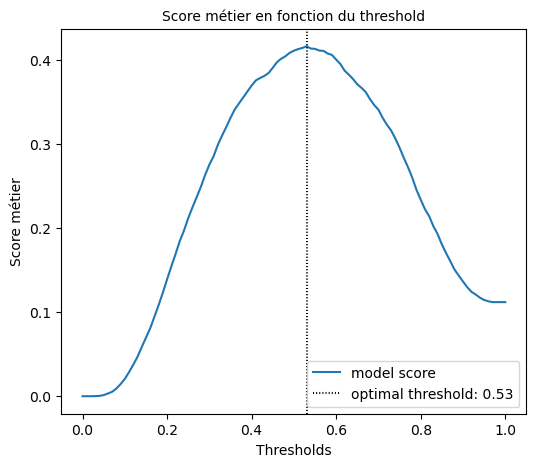

In [85]:
score_metier_max(y_pred_proba, y_val, verbose=True)

Après optimisation des hyperparamètres, nous obtenons un score métier à 0.41, qui est plus élevé que celui du modèle de base.

## <a id="7.6"> 7.6 Light GBM </a>

In [109]:
# params = {'learning_rate': [0.01, 0.1],
#           'num_leaves': [31, 63],
#           'n_estimators' : [100, 200]
          
#          }

params= {'n_estimators' : [100, 300, 500, 800],
          'max_depth': [-1,2,5, 7],
          'num_leaves': [7, 15, 31, 63, 127],
          'learning_rate': [0.05, 0.1, 0.2, 0.4]}

with mlflow.start_run(run_name='Grid Light GBM'):
    lgbm = LGBMClassifier(random_state=0)
    grid_lgbm = GridSearchCV(
        lgbm,
        param_grid=params,
        cv=5,
        scoring=make_scorer(score_metier),
        return_train_score = True,
        n_jobs = -1)
    
    grid_lgbm.fit(X_train_scaled, y_train)

In [111]:
result_lgbm = pd.DataFrame(grid_lgbm.cv_results_)
result_lgbm.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       8.227796      0.157292         0.235707        0.020329   
1      11.188530      0.313772         0.189840        0.024729   
2      15.597607      0.660342         0.238748        0.019906   
3      25.356019      0.314798         0.270015        0.011416   
4      39.567424      0.512387         0.298623        0.015333   

  param_learning_rate param_max_depth param_n_estimators param_num_leaves  \
0                0.05              -1                100                7   
1                0.05              -1                100               15   
2                0.05              -1                100               31   
3                0.05              -1                100               63   
4                0.05              -1                100              127   

                                              params  split0_test_score  \
0  {'learning_rate': 0.05, 'max_depth': -1, 'n_es...                NaN   
1  {'learning_rate': 0.05, 'max_depth': -1, 'n_es...                NaN   
2  {'learning_rate': 0.05, 'max_depth': -1, 'n_es...                NaN   
3  {'learning_rate': 0.05, 'max_depth': -1, 'n_es...                NaN   
4  {'learning_rate': 0.05, 'max_depth': -1, 'n_es...                NaN   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0                NaN                NaN                NaN                NaN   
1                NaN                NaN                NaN                NaN   
2                NaN                NaN                NaN                NaN   
3                NaN                NaN                NaN                NaN   
4                NaN                NaN                NaN                NaN   

   mean_test_score  std_test_score  rank_test_score  split0_train_score  \
0              NaN             NaN      -2147483648                 NaN   
1              NaN             NaN      -2147483648                 NaN   
2              NaN             NaN      -2147483648                 NaN   
3              NaN             NaN      -2147483648                 NaN   
4              NaN             NaN      -2147483648                 NaN   

   split1_train_score  split2_train_score  split3_train_score  \
0                 NaN                 NaN                 NaN   
1                 NaN                 NaN                 NaN   
2                 NaN                 NaN                 NaN   
3                 NaN                 NaN                 NaN   
4                 NaN                 NaN                 NaN   

   split4_train_score  mean_train_score  std_train_score  
0                 NaN               NaN              NaN  
1                 NaN               NaN              NaN  
2                 NaN               NaN              NaN  
3                 NaN               NaN              NaN  
4                 NaN               NaN              NaN

In [112]:
print('Meilleurs paramètres',grid_lgbm.best_params_)
print("Résultats des meilleurs paramètres :\n")
display(result_lgbm.loc[result_lgbm['params']==grid_lgbm.best_params_])

Meilleurs paramètres {'learning_rate': 0.05, 'max_depth': -1, 'n_estimators': 100, 'num_leaves': 7}
Résultats des meilleurs paramètres :



mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       8.227796      0.157292         0.235707        0.020329   

  param_learning_rate param_max_depth param_n_estimators param_num_leaves  \
0                0.05              -1                100                7   

                                              params  split0_test_score  \
0  {'learning_rate': 0.05, 'max_depth': -1, 'n_es...                NaN   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0                NaN                NaN                NaN                NaN   

   mean_test_score  std_test_score  rank_test_score  split0_train_score  \
0              NaN             NaN      -2147483648                 NaN   

   split1_train_score  split2_train_score  split3_train_score  \
0                 NaN                 NaN                 NaN   

   split4_train_score  mean_train_score  std_train_score  
0                 NaN               NaN              NaN

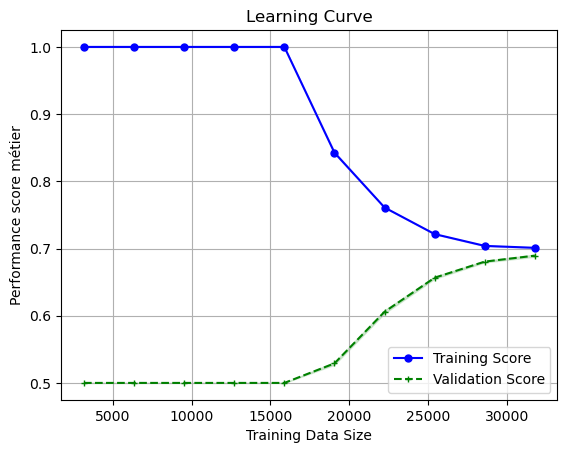

In [113]:
plot_learning_curve(grid_lgbm.best_estimator_, X_train_scaled, y_train)

Score métier :0.39
Accuracy score : 0.70
Precision score : 0.17
Recall score : 0.69
F1 score : 0.27
Fbeta score : 0.42
ROC AUC score : 0.69


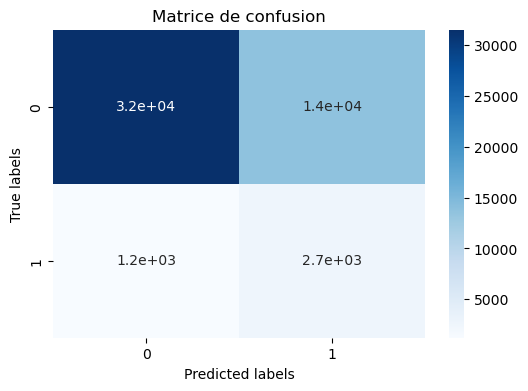

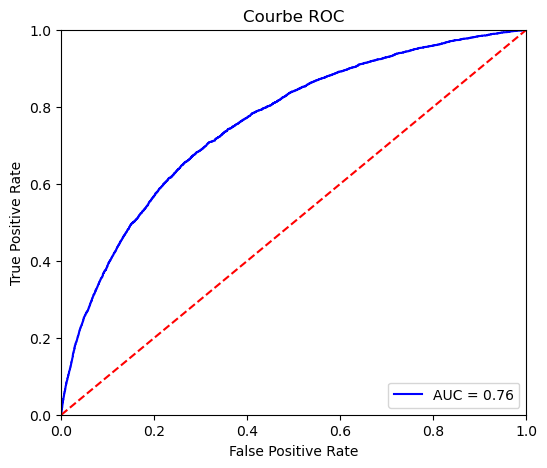

In [115]:
with mlflow.start_run(run_name='Light GBM optimise'):
    # Calcul et enregistrement des metriques sur les données de validation
    score_metier, accuracy, precision, recall, f1_score, fbeta_score, rocauc, y_pred_proba =\
    eval_score(grid_lgbm, X_val_scaled, y_val)
   
    mlflow.log_metric("val_score_métier", score_metier)
    mlflow.log_metric("val_accuracy", accuracy)
    mlflow.log_metric("val_precision", precision)
    mlflow.log_metric("val_recall", recall)
    mlflow.log_metric("val_f1_score", f1_score)
    mlflow.log_metric("val_fbeta_score", fbeta_score)
    mlflow.log_metric("val_rocauc", rocauc)

Score métier maximum : 0.40
Threshold optimal : 0.53


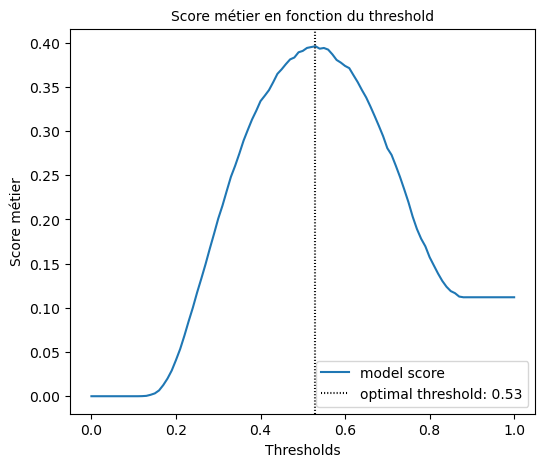

In [116]:
score_metier_max(y_pred_proba, y_val, verbose=True)

Après optimisation des hyperparamètres, nous obtenons un score métier à 0.40, ce qui ne change pas par rapport au modèle de base. Les hyperparamètres optimaux ne semblent pas avoir d'impact significatifs sur les performances de notre modèle.

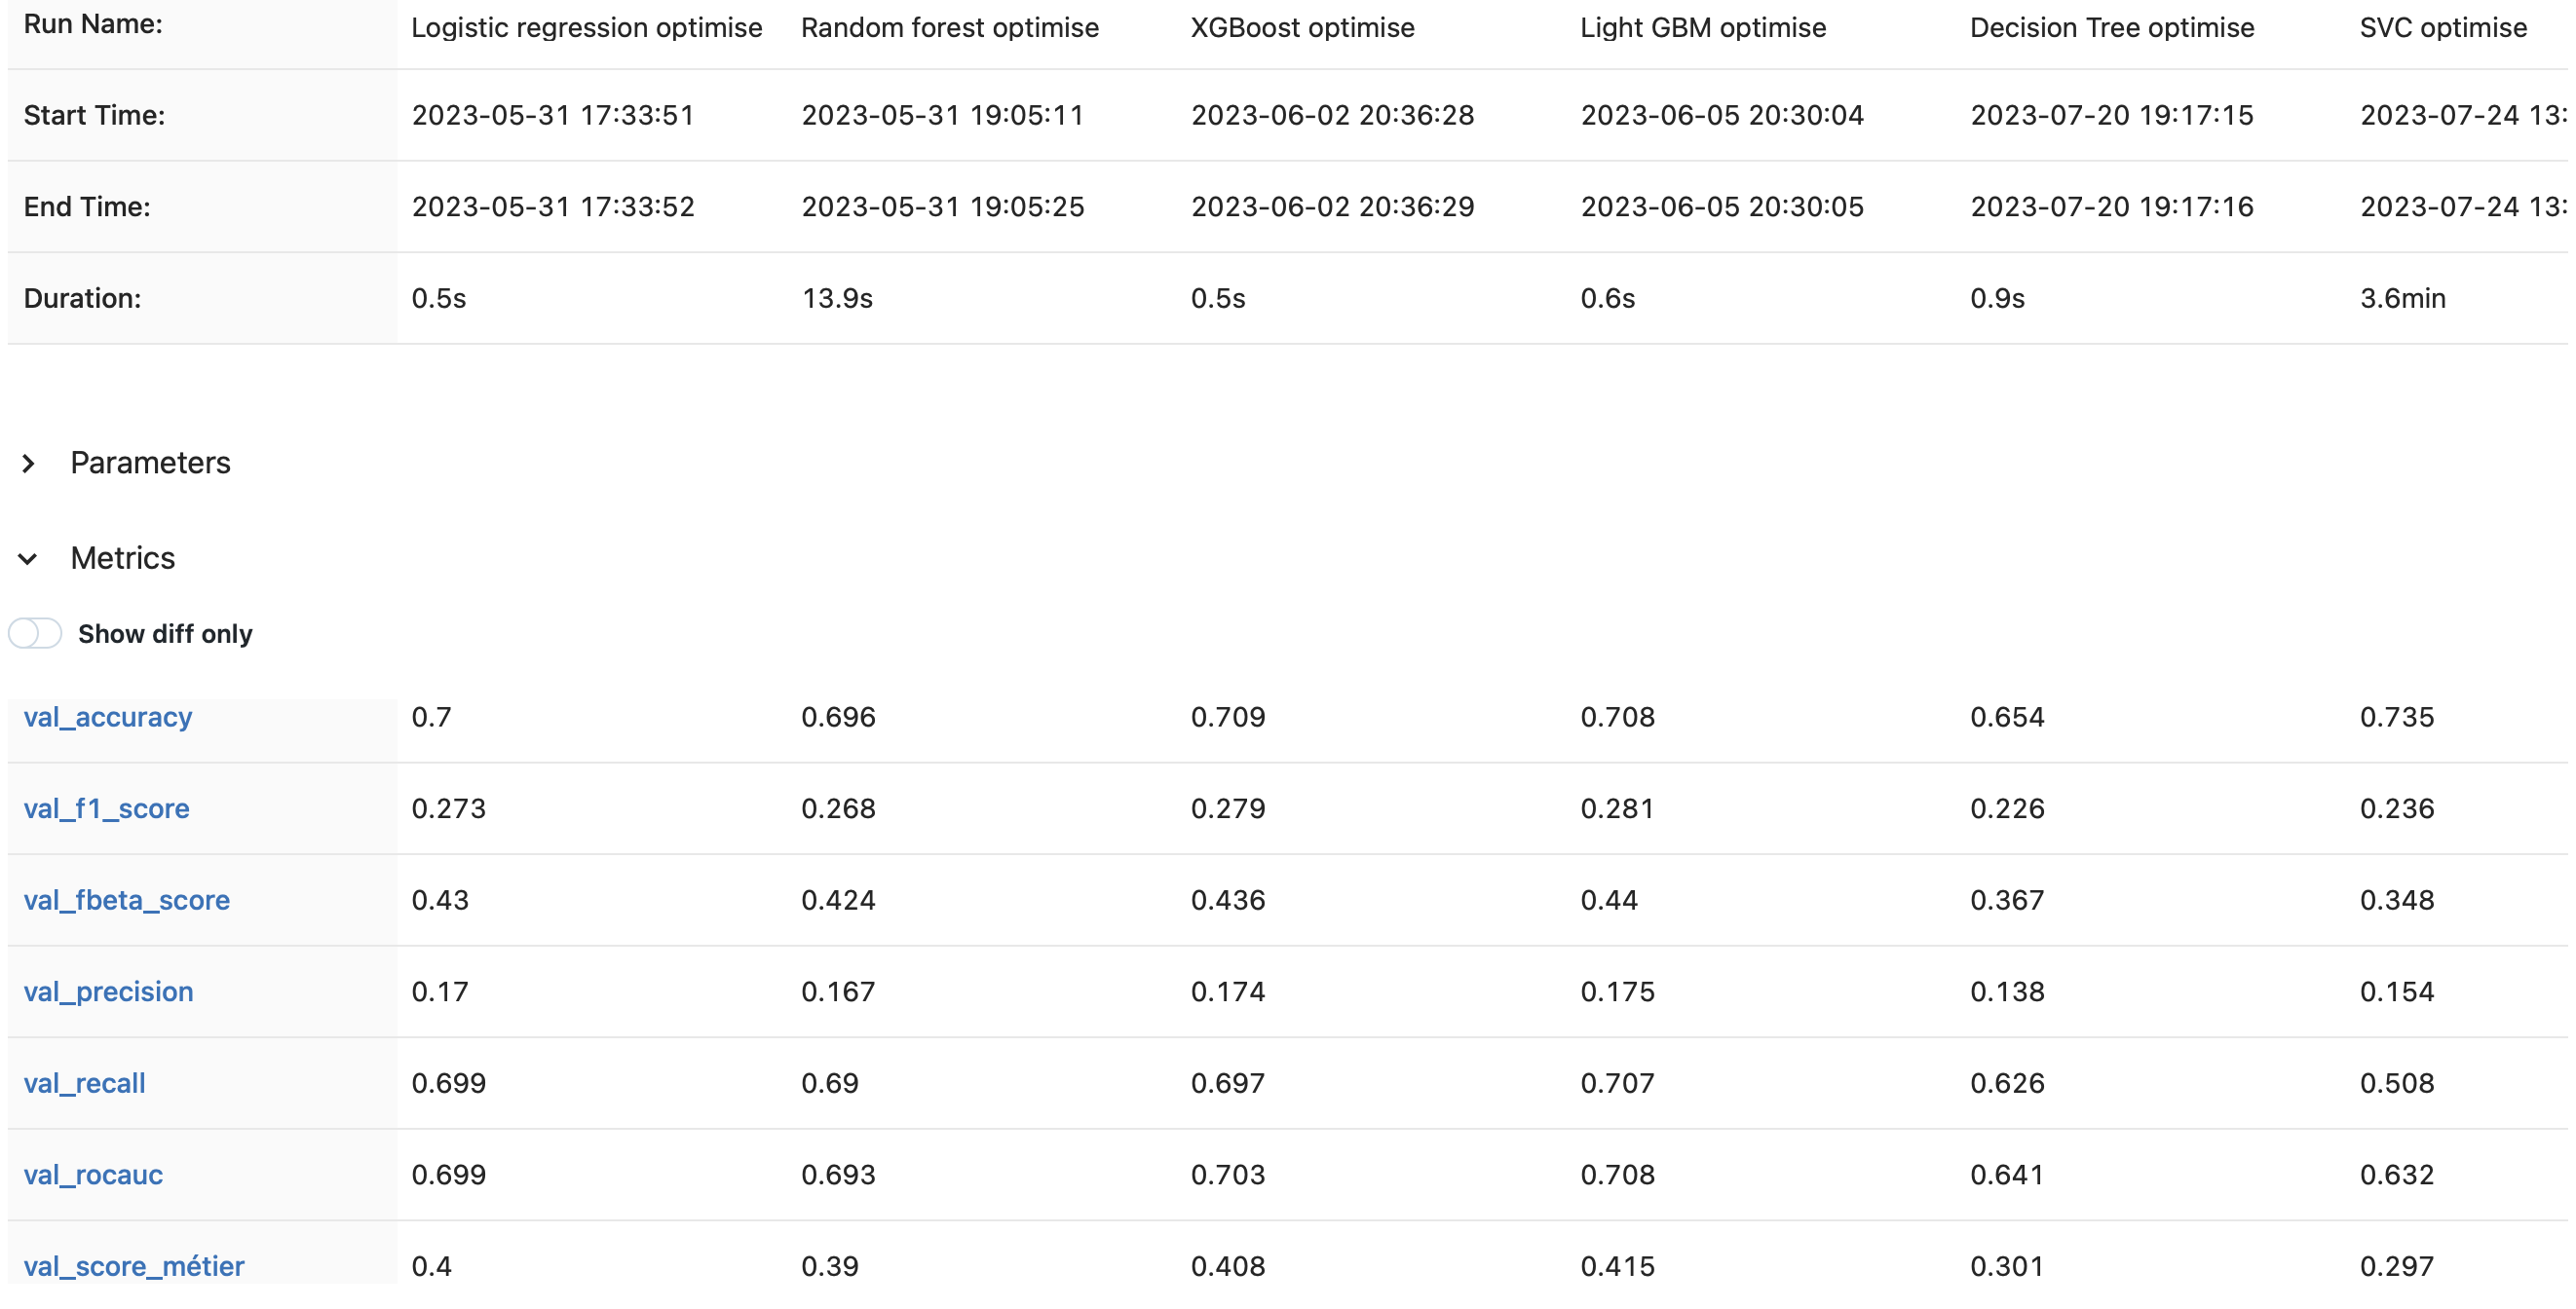

## <a id="8">8. Selection du modèle</a>

Le modèle Light GBM avec les hyperparamètres suivants : *'max_depth': -1,learning_rate': 0.05, 'n_estimators': 100, 'num_leaves': 15*
est le modèle le plus performant. Nous allons donc utiliser ce modèle par la suite. Nous décidons dans un premier temps de réaliser une grid search plus poussée avec l'algorithme Light GBM afin de tenter d'obtenir de meilleures performances.

In [117]:
score_metier = metrics.make_scorer(fonction_metier, greater_is_better=True)

In [118]:
params = {'n_estimators' : [100, 300, 500, 800],
          'max_depth': [-1, 2, 5, 7],
          'num_leaves': [7, 15, 31, 63, 127],
          'learning_rate': [0.05, 0.1, 0.2, 0.4]
         }

mlflow.lightgbm.autolog(log_input_examples=True, silent=True)
with mlflow.start_run(run_name='Grid finale Light GBM'):
    lgbm_fin = LGBMClassifier(random_state=0)
    grid_lgbm_fin = GridSearchCV(
        lgbm_fin,
        param_grid=params,
        cv=5,
        scoring=score_metier,
        return_train_score = True,
        n_jobs = -1)
    
    grid_lgbm_fin.fit(X_train_scaled, y_train)

In [119]:
result_lgbm_fin = pd.DataFrame(grid_lgbm_fin.cv_results_)
result_lgbm_fin.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       7.925156      0.434577         0.173031        0.027036   
1      10.818370      0.220913         0.181495        0.016251   
2      15.809713      0.807589         0.254863        0.045624   
3      26.438442      0.406161         0.283179        0.008902   
4      38.414782      2.852301         0.285666        0.010130   

  param_learning_rate param_max_depth param_n_estimators param_num_leaves  \
0                0.05              -1                100                7   
1                0.05              -1                100               15   
2                0.05              -1                100               31   
3                0.05              -1                100               63   
4                0.05              -1                100              127   

                                              params  split0_test_score  \
0  {'learning_rate': 0.05, 'max_depth': -1, 'n_es...          -1.210096   
1  {'learning_rate': 0.05, 'max_depth': -1, 'n_es...          -1.169940   
2  {'learning_rate': 0.05, 'max_depth': -1, 'n_es...          -1.146274   
3  {'learning_rate': 0.05, 'max_depth': -1, 'n_es...          -1.142246   
4  {'learning_rate': 0.05, 'max_depth': -1, 'n_es...          -1.134819   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0          -1.166037          -1.273917          -1.226964          -1.227341   
1          -1.140987          -1.190836          -1.171450          -1.143756   
2          -1.144637          -1.181898          -1.133056          -1.144512   
3          -1.081949          -1.148666          -1.124245          -1.134063   
4          -1.136707          -1.192976          -1.166667          -1.141113   

   mean_test_score  std_test_score  rank_test_score  split0_train_score  \
0        -1.220871        0.034686              255           -1.174912   
1        -1.163394        0.018700              145           -1.054947   
2        -1.150076        0.016597              111           -0.890830   
3        -1.126234        0.023605                5           -0.632773   
4        -1.154456        0.022412              119           -0.211669   

   split1_train_score  split2_train_score  split3_train_score  \
0           -1.147029           -1.152851           -1.159680   
1           -1.012053           -1.030621           -1.043020   
2           -0.873899           -0.871790           -0.873584   
3           -0.610964           -0.615433           -0.607912   
4           -0.211103           -0.199616           -0.195777   

   split4_train_score  mean_train_score  std_train_score  
0           -1.162103         -1.159315         0.009422  
1           -1.020833         -1.032295         0.015310  
2           -0.869115         -0.875843         0.007683  
3           -0.594285         -0.612273         0.012446  
4           -0.197350         -0.203103         0.006875

In [120]:
print('Meilleurs paramètres',grid_lgbm_fin.best_params_)
print("Résultats des meilleurs paramètres :\n")
display(result_lgbm_fin.loc[result_lgbm_fin['params']==grid_lgbm_fin.best_params_])

Meilleurs paramètres {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 300, 'num_leaves': 15}
Résultats des meilleurs paramètres :



mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
86      21.005265      0.469926         0.310499        0.020858   

   param_learning_rate param_max_depth param_n_estimators param_num_leaves  \
86                 0.1              -1                300               15   

                                               params  split0_test_score  \
86  {'learning_rate': 0.1, 'max_depth': -1, 'n_est...          -1.147155   

    split1_test_score  split2_test_score  split3_test_score  \
86          -1.103348           -1.12286          -1.108258   

    split4_test_score  mean_test_score  std_test_score  rank_test_score  \
86          -1.108635        -1.118051        0.015943                1   

    split0_train_score  split1_train_score  split2_train_score  \
86            -0.58604           -0.566339            -0.56442   

    split3_train_score  split4_train_score  mean_train_score  std_train_score  
86           -0.555042           -0.548905         -0.564149         0.012644

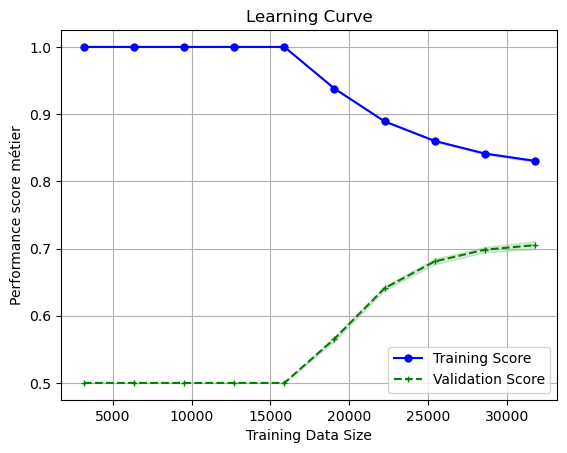

In [252]:
plot_learning_curve(grid_lgbm_fin.best_estimator_, X_train_scaled, y_train)

La learning curve nous informe que les deux courbes se rapprochent lorsque l'échantillon augmente. Elles semblent se stabiliser à droite du graphique, lorsque l'échantillon arrive à son maximum. 

Score métier :0.42
Accuracy score : 0.71
Precision score : 0.18
Recall score : 0.71
F1 score : 0.28
Fbeta score : 0.44
ROC AUC score : 0.71


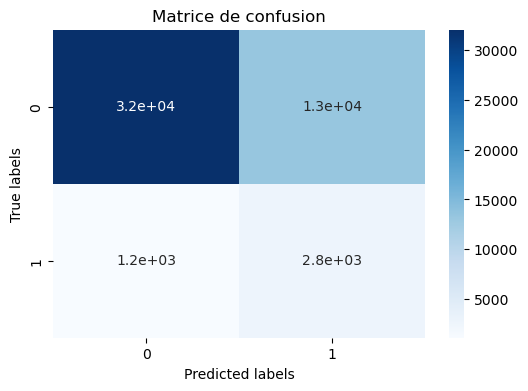

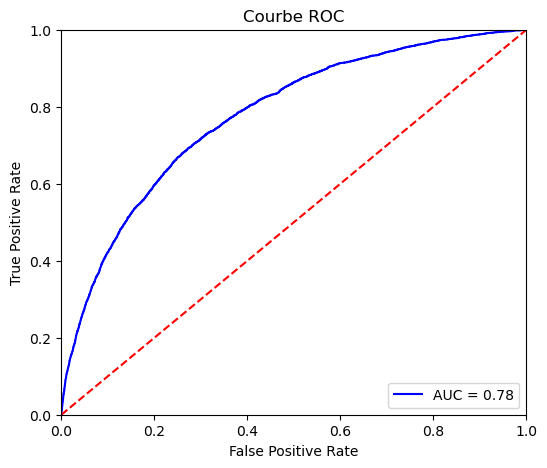

In [122]:
mlflow.lightgbm.autolog(log_input_examples=True, silent=True)
with mlflow.start_run(run_name='Light GBM final optimise'):
    # Calcul et enregistrement des metriques sur les données de validation
    score_metier, accuracy, precision, recall, f1_score, fbeta_score, rocauc, y_pred_proba =\
    eval_score(grid_lgbm_fin, X_val_scaled, y_val)
   
    mlflow.log_metric("val_score_métier", score_metier)
    mlflow.log_metric("val_accuracy", accuracy)
    mlflow.log_metric("val_precision", precision)
    mlflow.log_metric("val_recall", recall)
    mlflow.log_metric("val_f1_score", f1_score)
    mlflow.log_metric("val_fbeta_score", fbeta_score)
    mlflow.log_metric("val_rocauc", rocauc)

Score métier maximum : 0.42
Threshold optimal : 0.53


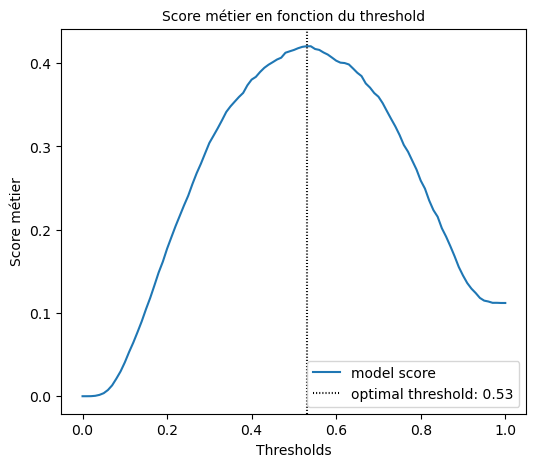

In [123]:
score_metier_max(y_pred_proba, y_val, verbose=True)

Score métier :0.42
Accuracy score : 0.74
Precision score : 0.19
Recall score : 0.68
F1 score : 0.29
Fbeta score : 0.44
ROC AUC score : 0.71


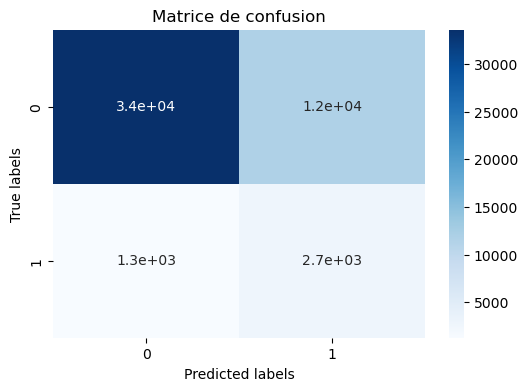

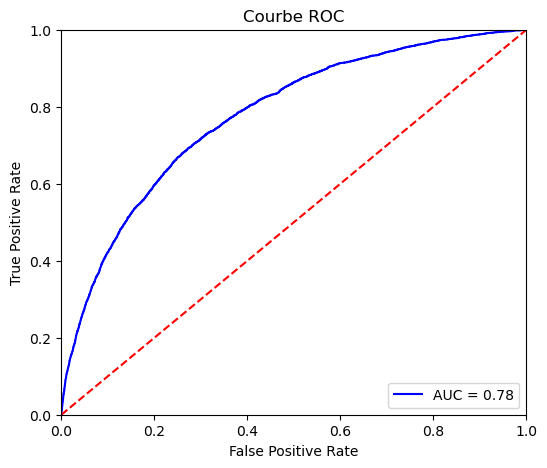

In [130]:
# {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 300, 'num_leaves': 15}

mlflow.autolog(log_input_examples=True, silent=True)
with mlflow.start_run(run_name='model select'):
#     lgbm_final = LGBMClassifier(learning_rate=0.1, max_depth=-1, n_estimators=500, num_leaves=31, random_state=0)
    lgbm_final = LGBMClassifier(learning_rate=0.1, max_depth=-1, n_estimators=300, num_leaves=15, random_state=0)
    lgbm_final.fit(X_train_scaled, y_train)
    
    # Calcul et enregistrement des metriques sur les données de validation
    score_metier, accuracy, precision, recall, f1_score, fbeta_score, rocauc, y_pred_proba =\
    eval_score(lgbm_final, X_val_scaled, y_val, seuil=0.53)
   
    mlflow.log_metric("val_score_métier", score_metier)
    mlflow.log_metric("val_accuracy", accuracy)
    mlflow.log_metric("val_precision", precision)
    mlflow.log_metric("val_recall", recall)
    mlflow.log_metric("val_f1_score", f1_score)
    mlflow.log_metric("val_fbeta_score", fbeta_score)
    mlflow.log_metric("val_rocauc", rocauc)

Notre modèle final est donc un Light GBM avec les paramètres *learning_rate=0.1, max_depth=-1, n_estimators=300, num_leaves=15* et un seuil à 0.53.
Nous intégrons également une pipeline d'entraînement du modèle avec standardisation des données et undersampling.

Score métier :0.41
Accuracy score : 0.74
Precision score : 0.18
Recall score : 0.67
F1 score : 0.29
Fbeta score : 0.44
ROC AUC score : 0.70


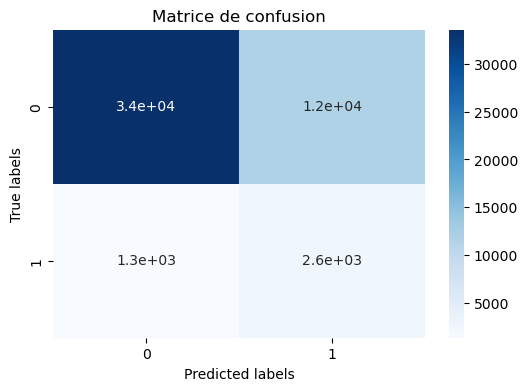

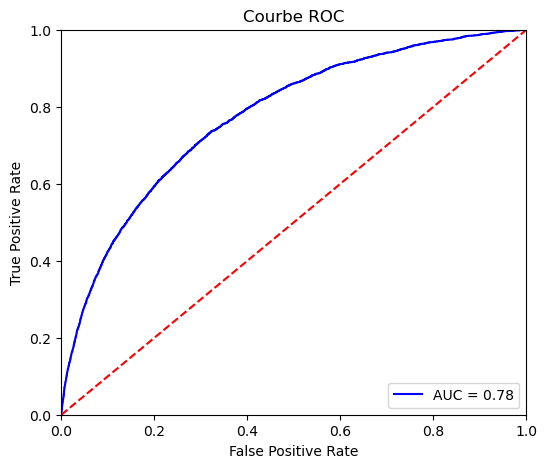

In [174]:
cols = X_train_scaled.select_dtypes(['float64']).columns
preprocessor = ColumnTransformer([('quanti',StandardScaler(),cols)],remainder='passthrough')

pipe = Pipeline(steps = [['scaler', preprocessor],
                         ['sampling',RandomUnderSampler()],
                         ['classifier', LGBMClassifier(
                                                       learning_rate=0.1,
                                                       max_depth=-1,
                                                       n_estimators=300,
                                                       num_leaves=15,
                                                       random_state=0
                         )
                         ]
                        ])

mlflow.lightgbm.autolog(log_input_examples=True, silent=True)
with mlflow.start_run(run_name='pip final'):
    pipe.fit(X_train_scaled, y_train)
    
    # Calcul et enregistrement des metriques sur les données de validation
    score_metier, accuracy, precision, recall, f1_score, fbeta_score, rocauc, y_pred_proba =\
    eval_score(pipe, X_val_scaled, y_val, seuil=0.53)
   
    mlflow.log_metric("val_score_métier", score_metier)
    mlflow.log_metric("val_accuracy", accuracy)
    mlflow.log_metric("val_precision", precision)
    mlflow.log_metric("val_recall", recall)
    mlflow.log_metric("val_f1_score", f1_score)
    mlflow.log_metric("val_fbeta_score", fbeta_score)
    mlflow.log_metric("val_rocauc", rocauc)

Score métier maximum : 0.41
Threshold optimal : 0.53


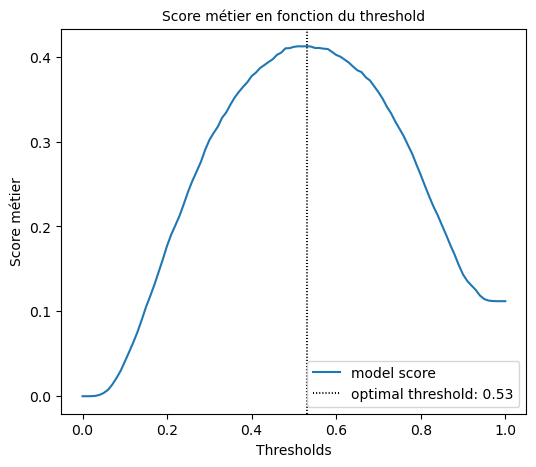

In [175]:
score_metier_max(y_pred_proba, y_val, verbose=True)

Le score métier est de 0.41.

La matrice de confusion nous permet de constater que les FN sont présents en moins grande quantité que les autres catégories. 

Le f-béta score est effectivement plus élevé que le f-score puisque le recall est plus élevé que la précision, ce score étant établit ici pour privilégier le recall à la précision.

On constate que le score ROC AUC est amélioré par rapport à la baseline et est de 0.71.
L'accuracy est quant à lui de 0.74.

Score métier :0.41
Accuracy score : 0.73
Precision score : 0.18
Recall score : 0.68
F1 score : 0.29
Fbeta score : 0.44
ROC AUC score : 0.71


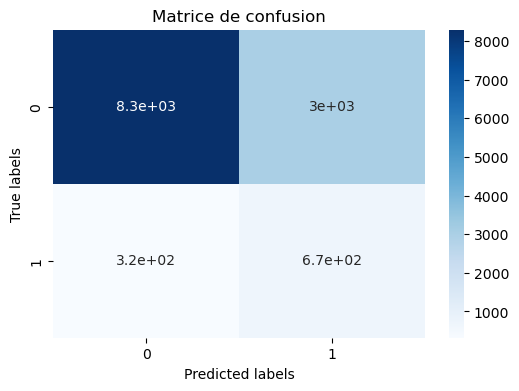

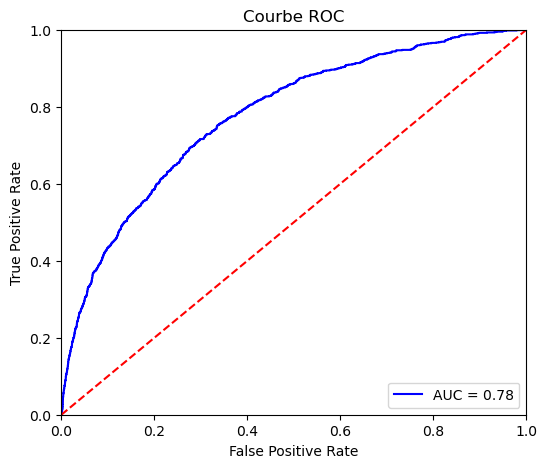

In [176]:
mlflow.lightgbm.autolog(log_input_examples=True, silent=True)
with mlflow.start_run(run_name='pip jeu test'):
    
    # Calcul et enregistrement des metriques sur les données de validation
    score_metier, accuracy, precision, recall, f1_score, fbeta_score, rocauc, y_pred_proba =\
    eval_score(pipe, X_val_test_scaled, y_val_test, seuil=0.53) 
   
    mlflow.log_metric("val_score_métier", score_metier)
    mlflow.log_metric("val_accuracy", accuracy)
    mlflow.log_metric("val_precision", precision)
    mlflow.log_metric("val_recall", recall)
    mlflow.log_metric("val_f1_score", f1_score)
    mlflow.log_metric("val_fbeta_score", fbeta_score)
    mlflow.log_metric("val_rocauc", rocauc)

L'application de la pipeline sur le jeu de test nous donne des résultats similaires à ceux du jeu de validation.

In [177]:
from mlflow.models.signature import infer_signature

In [178]:
signature = infer_signature(X_train, y_train)
mlflow.sklearn.save_model(pipe, 'mlflow_model', signature=signature)

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (trai

In [179]:
pipe = pickle.load(open('mlflow_model/model.pkl', 'rb'))

## <a id="9">9. SHAP </a>


Nous allons désormais expliquer notre modèle avec les valeurs de SHAP. 

SHAP (SHapley Additive exPlanations) est une approche théorique et pratique pour expliquer les prédictions des modèles d'apprentissage automatique. L'objectif de SHAP est de fournir des explications interprétables pour les prédictions de modèles complexes. Il permet de comprendre comment chaque feature contribue à la prédiction finale, en attribuant des valeurs d'importance à chacune.

SHAP permet de fournir à la fois des explications globales, qui s'appliquent à l'ensemble du modèle, et des explications locales, qui sont spécifiques à une prédiction individuelle.

In [180]:
explainer_pipe = shap.TreeExplainer(pipe['classifier'])
shap_values_pipe = explainer_pipe.shap_values(X_val_scaled)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


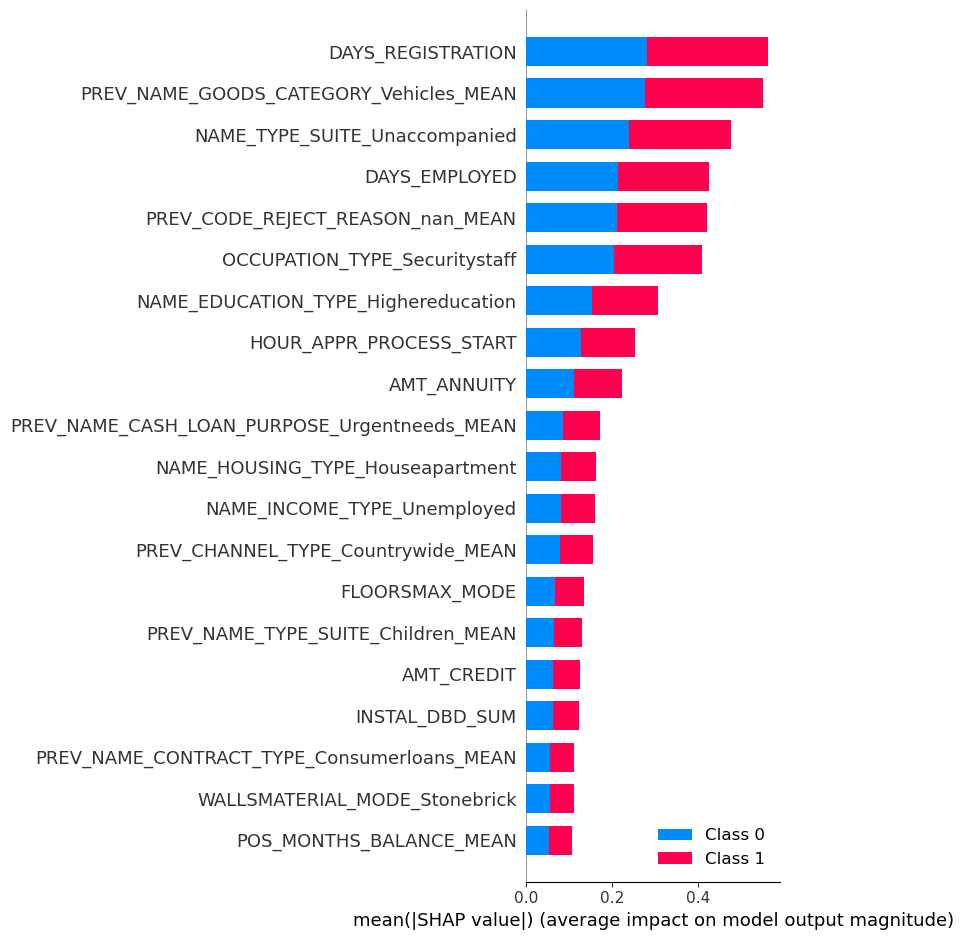

In [181]:
shap.summary_plot(shap_values_pipe, X_val_scaled, plot_type='bar')

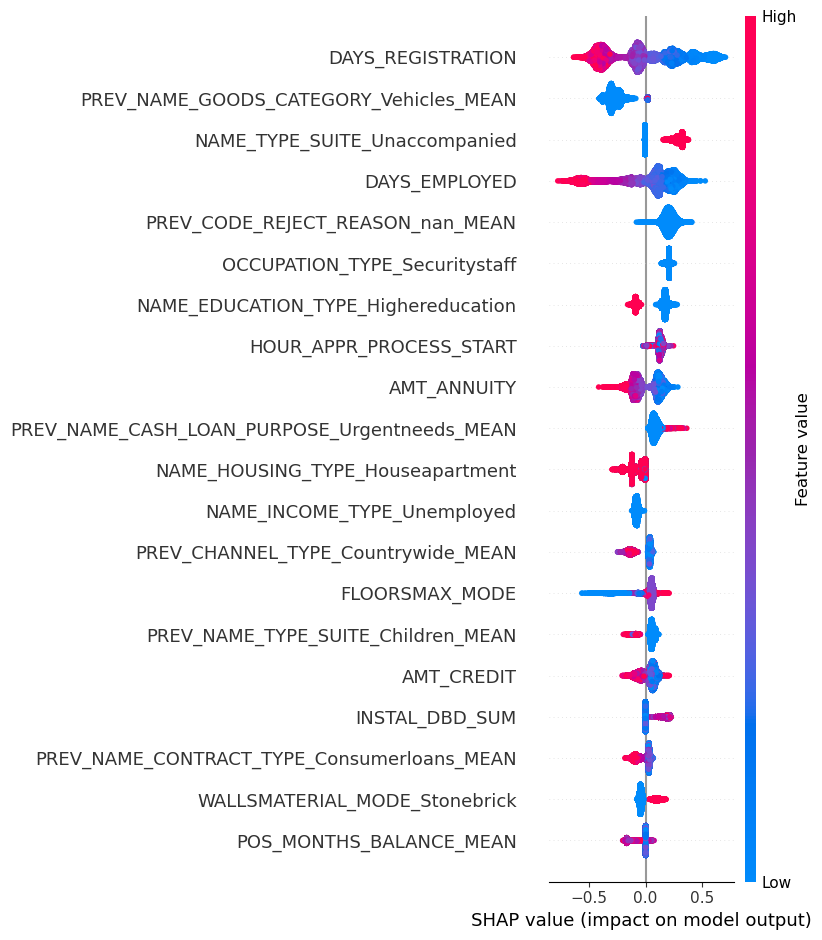

In [182]:
shap.summary_plot(shap_values_pipe[1], X_val_scaled.values, feature_names = X_val_scaled.columns)

Nous commençons l'analyse d'importance, d'un point de vue global, avec les features les plus importantes pour un modèle basé sur un ensemble de validation. Ici, nous avons utilisé *summary_plot*. Ce type de tracé agrège les valeurs SHAP pour toutes les features et tous les échantillons de l'ensemble sélectionné. Ensuite, les valeurs SHAP sont triées, de sorte que la première affichée est la feature la plus importante. En plus de cela, nous recevons des informations sur la façon dont chaque feature affecte la sortie du modèle. Le graphique utilise les valeurs SHAP pour montrer la distribution des impacts de chaque feature sur la sortie du modèle.

Les deux features les plus importantes sont *PREV_NAME_CLIENT_TYPE_XNA_MEAN* et *DAYS_REGISTRATION*. Pour les deux, leurs valeurs faibles poussent la prédiction vers 1 (soit le client fait défaut).
On peut constater que cette tendance s'inverse pour d'autres features telles que *NAME_TYPE_SUITE_Unaccompanied* par exemple.

In [183]:
i = 0
shap.initjs()
print("Individu ID: {}".format(X_val_scaled.index[i]))
shap.force_plot(explainer_pipe.expected_value[1],
                shap_values_pipe[1][i],
                X_val_scaled.values[i],
                feature_names = X_val_scaled.columns)

Individu ID: 159410


In [184]:
i = 1
shap.initjs()
print("Individu ID: {}".format(X_val_scaled.index[i]))
shap.force_plot(explainer_pipe.expected_value[1],
                shap_values_pipe[1][i],
                X_val_scaled.values[i],
                feature_names = X_val_scaled.columns)

Individu ID: 190659


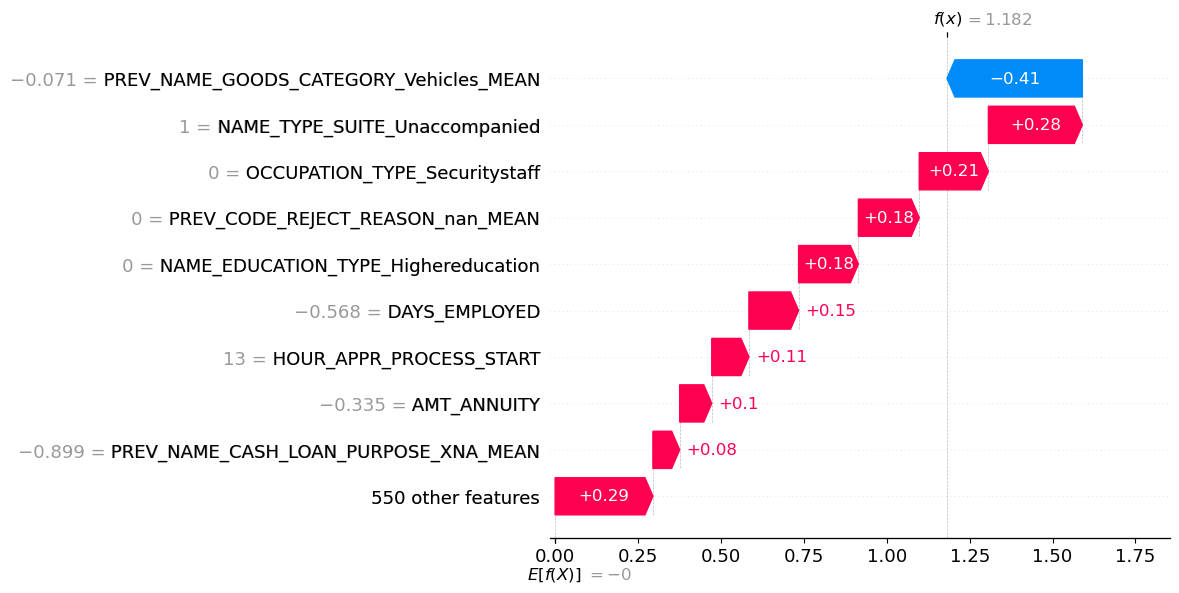

In [185]:
# Individu ID: 284800
shap.waterfall_plot(explainer_pipe(X_val_scaled)[0][:,1])

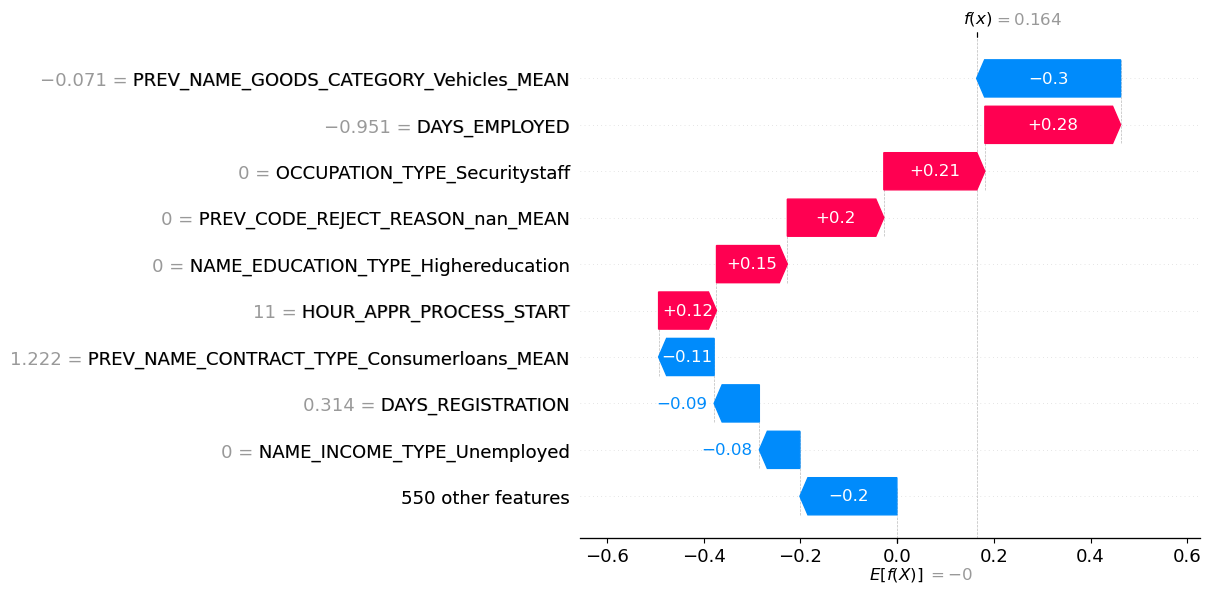

In [186]:
# Individu ID: 321072
shap.waterfall_plot(explainer_pipe(X_val_scaled)[1][:,1])

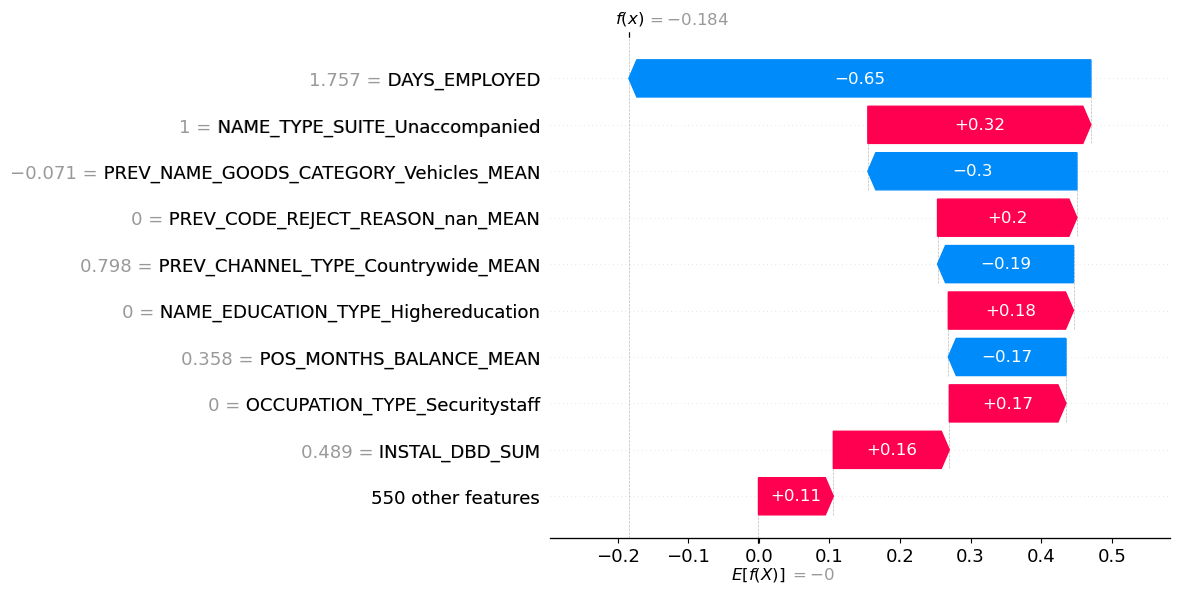

In [187]:
# Individu ID: 124755
shap.waterfall_plot(explainer_pipe(X_val_scaled)[2][:,1])

D'un point de vue local, on s'interesse cette fois-ci à l'impact des features pour la décision du modèle par rapport à une observation en particulier.

Dans les graphes ci-dessus, on peut voir l’impact de chacune des caractéristiques de l’individu choisi et comment ces caractéristiques impactent la prédiction. En bleu sont représentées les caractéristiques ayant une SHAPley valeur négative et donc une contribution négative et en rouge les caractéristiques ayant une SHAPley valeur positive, donc une contribution positive. 

Pour le client ID 284800 par exemple, on voit que les deux features les plus influentes dans la décision de la sortie de ce client sont celles citées précédemment.
A l'inverse, pour le client 124755, la feature la plus influente est *DAYS_EMPLOYED* et a une contribution négative sur la décision de ce client.